In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from scipy.stats import spearmanr, kendalltau

# 1) Universe
tickers = ['AAPL','MSFT','GOOGL','AMZN','JPM','BAC','WMT','XOM','JNJ']
start = datetime(1990,1,1)
end = datetime.today()

# 2) Download daily OHLCV from Stooq
def download_stooq(ts, start, end):
    frames = []
    for t in ts:
        try:
            df = pdr.DataReader(t, 'stooq', start, end).sort_index()
            df.columns = pd.MultiIndex.from_product([[t], df.columns])
            frames.append(df)
        except Exception as e:
            print(f"Error downloading {t}: {e}")
    return pd.concat(frames, axis=1)

raw = download_stooq(tickers, start, end)
# Extract OHLC and Volume
open_ = raw.xs('Open', level=1, axis=1)
high  = raw.xs('High', level=1, axis=1)
low   = raw.xs('Low',  level=1, axis=1)
close = raw.xs('Close',level=1, axis=1)
vol   = raw.xs('Volume', level=1, axis=1)

# Compute daily returns on close
rets = close.pct_change().dropna()

# 3) Combine raw price/volume features
feat_list = []
# include raw OHLC and volume
feat_list.append(open_.add_suffix('_open'))
feat_list.append(high.add_suffix('_high'))
feat_list.append(low.add_suffix('_low'))
feat_list.append(vol.add_suffix('_vol'))

# 4) Rolling stats on returns
W = 21
for t in tickers:
    r = rets[t]
    feat_list.append(pd.DataFrame({
        f"{t}_roll_mean": r.rolling(W).mean(),
        f"{t}_roll_var":  r.rolling(W).var(),
        f"{t}_roll_skew": r.rolling(W).skew()
    }))

# 5) Correlations AAPL vs others
base = rets['AAPL']
for t in tickers:
    if t == 'AAPL': continue
    r = rets[t]
    feat_list.append(pd.DataFrame({
        f"AAPL_{t}_pear":  base.rolling(W).corr(r),
        f"AAPL_{t}_spear": base.rolling(W).apply(lambda w: spearmanr(w, r.loc[w.index])[0], raw=False),
        f"AAPL_{t}_kend":  base.rolling(W).apply(lambda w: kendalltau(w, r.loc[w.index])[0], raw=False)
    }))

# 6) Technical indicators
ema_periods = [3, 6, 12]
for p in ema_periods:
    ema = close.ewm(span=p, adjust=False).mean()
    feat_list.append(ema.pct_change().add_suffix(f"_ema{p}"))
# MACD
macd = close.ewm(span=12, adjust=False).mean() - close.ewm(span=26, adjust=False).mean()
feat_list.append(macd.add_suffix("_macd"))
# RSI

def compute_rsi(series, period=14):
    delta = series.diff()
    up    = delta.clip(lower=0)
    down  = -delta.clip(upper=0)
    ma_up   = up.ewm(alpha=1/period, min_periods=period).mean()
    ma_down = down.ewm(alpha=1/period, min_periods=period).mean()
    return 100 - (100/(1 + ma_up/ma_down))
feat_list.append(close.apply(lambda c: compute_rsi(c, 14)).add_suffix("_rsi14"))

# Bollinger Bands (20-day)
window = 20
for t in tickers:
    ma = close[t].rolling(window).mean()
    std = close[t].rolling(window).std()
    feat_list.append(pd.DataFrame({
        f"{t}_bb_upper": ma + 2*std,
        f"{t}_bb_lower": ma - 2*std,
        f"{t}_bb_width": (ma + 2*std) - (ma - 2*std)
    }))

# On-Balance Volume (OBV)
for t in tickers:
    obv = (np.sign(close[t].diff()) * vol[t]).fillna(0).cumsum()
    feat_list.append(obv.rename(f"{t}_obv"))

# Average True Range (ATR)
high_low = high - low
high_prev_close = (high - close.shift(1)).abs()
low_prev_close = (low - close.shift(1)).abs()
# Compute True Range per ticker as the max of the three
tr = pd.DataFrame(index=close.index)
for t in tickers:
    tr[t] = pd.concat([high_low[t], high_prev_close[t], low_prev_close[t]], axis=1).max(axis=1)
# ATR: rolling mean of True Range
for t in tickers:
    atr = tr[t].rolling(window).mean()
    feat_list.append(atr.rename(f"{t}_atr"))

# Stochastic Oscillator %K (14-day)
for t in tickers:
    lowest_low = low[t].rolling(14).min()
    highest_high = high[t].rolling(14).max()
    stoch = 100 * (close[t] - lowest_low) / (highest_high - lowest_low)
    feat_list.append(stoch.rename(f"{t}_stoch_k"))

# Williams %R (14-day)
for t in tickers:
    highest_high = high[t].rolling(14).max()
    lowest_low = low[t].rolling(14).min()
    willr = -100 * (highest_high - close[t]) / (highest_high - lowest_low)
    feat_list.append(willr.rename(f"{t}_willr"))

# 7) Calendar features
cal = pd.DataFrame(index=close.index)
cal['dow']   = cal.index.dayofweek
cal['month'] = cal.index.month
feat_list.append(cal)

# 8) Macro from FRED (sans PMI)
fred_codes = {
    'FedFunds':    'FEDFUNDS',
    'US10Y':       'DGS10',
    'CPI':         'CPIAUCSL',
    'Unemployment':'UNRATE'
}
macro = pd.DataFrame(index=close.index)
for name, code in fred_codes.items():
    try:
        dfm = pdr.DataReader(code, 'fred', start, end)
        dfm = dfm.reindex(close.index).fillna(method='ffill')
        macro[name] = dfm[code]
    except Exception as e:
        print(f"Warning: could not load {name} ({code}): {e}")
feat_list.append(macro.pct_change().add_suffix("_mom1"))

# 9) Combine all features
features = pd.concat(feat_list, axis=1).dropna()

# 10) Target: AAPL next-day return
target = rets['AAPL'].shift(-1).loc[features.index].rename('target')
features, target = features.align(target, join='inner', axis=0)

# 11) Create df_all with features + target
df_all = features.copy()
df_all['target'] = target

# 12) Correlation scores of features vs target
# compute correlations for all features in df_all (excluding 'target')
pearson = df_all.drop(columns='target').corrwith(df_all['target'])
spearman = df_all.drop(columns='target').apply(lambda x: spearmanr(x, df_all['target'], nan_policy='omit')[0])
kendall = df_all.drop(columns='target').apply(lambda x: kendalltau(x, df_all['target'], nan_policy='omit')[0])

corr_df = pd.DataFrame({
    'pearson_abs': pearson.abs(),
    'spearman_abs': spearman.abs(),
    'kendall_abs': kendall.abs()
})
corr_df['max_abs_corr'] = corr_df.max(axis=1)
corr_df = corr_df.sort_values('max_abs_corr', ascending=False)
print("Top 20 features by absolute correlation with next-day AAPL return:")
print(corr_df.head(20))

Top 20 features by absolute correlation with next-day AAPL return:
             pearson_abs  spearman_abs  kendall_abs  max_abs_corr
XOM_ema3        0.071439      0.034680     0.023775      0.071439
XOM_ema6        0.059502      0.034128     0.023500      0.059502
BAC_ema3        0.049278      0.007183     0.004473      0.049278
WMT_ema6        0.047907      0.019777     0.013327      0.047907
XOM_ema12       0.047621      0.028782     0.019506      0.047621
AAPL_obv        0.047102      0.034382     0.023153      0.047102
BAC_ema6        0.046247      0.002568     0.001695      0.046247
WMT_ema12       0.044591      0.016266     0.010677      0.044591
JNJ_ema3        0.044202      0.000446     0.000154      0.044202
WMT_ema3        0.044094      0.015353     0.010286      0.044094
JPM_ema3        0.042756      0.005132     0.003311      0.042756
JPM_ema6        0.041800      0.003452     0.002335      0.041800
MSFT_ema3       0.041554      0.001174     0.000933      0.041554
JPM_ema12

In [263]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from scipy.stats import spearmanr, kendalltau
from itertools import combinations

# 1) Universe
tickers = ['AAPL','MSFT','GOOGL','AMZN','JPM','BAC','WMT','XOM','JNJ']
start = datetime(1990,1,1)
end = datetime.today()

# 2) Download daily OHLCV from Stooq
def download_stooq(ts, start, end):
    frames = []
    for t in ts:
        try:
            df = pdr.DataReader(t, 'stooq', start, end).sort_index()
            df.columns = pd.MultiIndex.from_product([[t], df.columns])
            frames.append(df)
        except Exception as e:
            print(f"Error downloading {t}: {e}")
    return pd.concat(frames, axis=1)

raw = download_stooq(tickers, start, end)
# Extract OHLC and Volume
open_ = raw.xs('Open', level=1, axis=1)
high  = raw.xs('High', level=1, axis=1)
low   = raw.xs('Low',  level=1, axis=1)
close = raw.xs('Close',level=1, axis=1)
vol   = raw.xs('Volume', level=1, axis=1)

# Compute daily returns on close
rets = close.pct_change().dropna()

# 3) Combine raw price/volume features
feat_list = []
feat_list.append(open_.add_suffix('_open'))
feat_list.append(high.add_suffix('_high'))
feat_list.append(low.add_suffix('_low'))
feat_list.append(vol.add_suffix('_vol'))

# 4) Rolling stats on returns (21-day)
W = 21
for t in tickers:
    r = rets[t]
    feat_list.append(pd.DataFrame({
        f"{t}_roll_mean": r.rolling(W).mean(),
        f"{t}_roll_var":  r.rolling(W).var(),
        f"{t}_roll_skew": r.rolling(W).skew()
    }))

# 4.1) Additional rolling stats on returns (5-day)
W_short = 5
for t in tickers:
    r = rets[t]
    feat_list.append(pd.DataFrame({
        f"{t}_roll_mean5": r.rolling(W_short).mean(),
        f"{t}_roll_var5":  r.rolling(W_short).var(),
        f"{t}_roll_skew5": r.rolling(W_short).skew()
    }))

# 4.2) Additional momentum and volatility features
for t in tickers:
    r = rets[t]
    feat_list.append((r - r.shift(5)).rename(f"{t}_mom5"))               # 5-day momentum
    feat_list.append(r.rolling(21).std().rename(f"{t}_vol21"))           # 21-day volatility
    feat_list.append(r.rolling(21).kurt().rename(f"{t}_roll_kurt"))      # 21-day kurtosis

# 5) Correlations AAPL vs others
base = rets['AAPL']
for t in tickers:
    if t == 'AAPL': continue
    r = rets[t]
    feat_list.append(pd.DataFrame({
        f"AAPL_{t}_pear":  base.rolling(W).corr(r),
        f"AAPL_{t}_spear": base.rolling(W).apply(lambda w: spearmanr(w, r.loc[w.index])[0], raw=False),
        f"AAPL_{t}_kend":  base.rolling(W).apply(lambda w: kendalltau(w, r.loc[w.index])[0], raw=False)
    }))

# 6) Technical indicators
ema_periods = [3, 6, 12]
for p in ema_periods:
    ema = close.ewm(span=p, adjust=False).mean()
    feat_list.append(ema.pct_change().add_suffix(f"_ema{p}"))
# MACD
macd = close.ewm(span=12, adjust=False).mean() - close.ewm(span=26, adjust=False).mean()
feat_list.append(macd.add_suffix("_macd"))
# RSI

def compute_rsi(series, period=14):
    delta = series.diff()
    up    = delta.clip(lower=0)
    down  = -delta.clip(upper=0)
    ma_up   = up.ewm(alpha=1/period, min_periods=period).mean()
    ma_down = down.ewm(alpha=1/period, min_periods=period).mean()
    return 100 - (100/(1 + ma_up/ma_down))
feat_list.append(close.apply(lambda c: compute_rsi(c, 14)).add_suffix("_rsi14"))

# Bollinger Bands (20-day)
window = 20
for t in tickers:
    ma = close[t].rolling(window).mean()
    std = close[t].rolling(window).std()
    feat_list.append(pd.DataFrame({
        f"{t}_bb_upper": ma + 2*std,
        f"{t}_bb_lower": ma - 2*std,
        f"{t}_bb_width": (ma + 2*std) - (ma - 2*std)
    }))

# On-Balance Volume (OBV)
for t in tickers:
    obv = (np.sign(close[t].diff()) * vol[t]).fillna(0).cumsum()
    feat_list.append(obv.rename(f"{t}_obv"))

# Average True Range (ATR)
high_low = high - low
high_prev_close = (high - close.shift(1)).abs()
low_prev_close = (low - close.shift(1)).abs()
tr = pd.DataFrame(index=close.index)
for t in tickers:
    tr[t] = pd.concat([high_low[t], high_prev_close[t], low_prev_close[t]], axis=1).max(axis=1)
for t in tickers:
    atr = tr[t].rolling(window).mean()
    feat_list.append(atr.rename(f"{t}_atr"))

# Stochastic Oscillator %K (14-day)
for t in tickers:
    lowest_low = low[t].rolling(14).min()
    highest_high = high[t].rolling(14).max()
    stoch = 100 * (close[t] - lowest_low) / (highest_high - lowest_low)
    feat_list.append(stoch.rename(f"{t}_stoch_k"))

# Williams %R (14-day)
for t in tickers:
    highest_high = high[t].rolling(14).max()
    lowest_low = low[t].rolling(14).min()
    willr = -100 * (highest_high - close[t]) / (highest_high - lowest_low)
    feat_list.append(willr.rename(f"{t}_willr"))

# 7) Calendar features
cal = pd.DataFrame(index=close.index)
cal['dow']   = cal.index.dayofweek
cal['month'] = cal.index.month
feat_list.append(cal)

# 8) Macro from FRED (sans PMI)
fred_codes = {
    'FedFunds':    'FEDFUNDS',
    'US10Y':       'DGS10',
    'CPI':         'CPIAUCSL',
    'Unemployment':'UNRATE'
}
macro = pd.DataFrame(index=close.index)
for name, code in fred_codes.items():
    try:
        dfm = pdr.DataReader(code, 'fred', start, end)
        dfm = dfm.reindex(close.index).fillna(method='ffill')
        macro[name] = dfm[code]
    except Exception as e:
        print(f"Warning: could not load {name} ({code}): {e}")
feat_list.append(macro.pct_change().add_suffix("_mom1"))

# 8.1) Cross-asset interaction features
for t1, t2 in combinations(tickers, 2):
    feat_list.append((rets[t1] * rets[t2]).rename(f"{t1}_{t2}_ret_prod"))
    feat_list.append((rets[t1] - rets[t2]).rename(f"{t1}_{t2}_ret_diff"))
    feat_list.append((rets[t1] / rets[t2]).rename(f"{t1}_{t2}_ret_ratio"))

# 9) Combine all features
features = pd.concat(feat_list, axis=1).dropna()

# 10) Target: AAPL next-day return
target = rets['AAPL'].shift(-1).loc[features.index].rename('target')
features, target = features.align(target, join='inner', axis=0)

# 11) Create df_all with features + target
df_all = features.copy()
df_all['target'] = target

# 12) Correlation scores of features vs target
pearson = df_all.drop(columns='target').corrwith(df_all['target'])
spearman = df_all.drop(columns='target').apply(lambda x: spearmanr(x, df_all['target'], nan_policy='omit')[0])
kendall = df_all.drop(columns='target').apply(lambda x: kendalltau(x, df_all['target'], nan_policy='omit')[0])

corr_df = pd.DataFrame({
    'pearson_abs': pearson.abs(),
    'spearman_abs': spearman.abs(),
    'kendall_abs': kendall.abs()
})
corr_df['max_abs_corr'] = corr_df.max(axis=1)
corr_df = corr_df.sort_values('max_abs_corr', ascending=False)
print("Top 20 features by absolute correlation with next-day AAPL return:")
print(corr_df.head(20))


Top 20 features by absolute correlation with next-day AAPL return:
                      pearson_abs  spearman_abs  kendall_abs  max_abs_corr
XOM_ema3                 0.071997      0.035177     0.024111      0.071997
AMZN_XOM_ret_diff        0.060365      0.045077     0.030522      0.060365
XOM_ema6                 0.060215      0.034634     0.023850      0.060215
XOM_JNJ_ret_diff         0.053216      0.034196     0.022859      0.053216
WMT_XOM_ret_diff         0.052626      0.035236     0.023768      0.052626
AMZN_BAC_ret_diff        0.051312      0.033034     0.022401      0.051312
BAC_ema3                 0.049757      0.007507     0.004697      0.049757
WMT_ema6                 0.048717      0.020162     0.013572      0.048717
XOM_ema12                0.048473      0.029524     0.020012      0.048473
AAPL_obv                 0.047300      0.034293     0.023098      0.047300
BAC_ema6                 0.047038      0.002986     0.001972      0.047038
GOOGL_AMZN_ret_ratio          NaN

In [264]:
from tqdm import tqdm

In [310]:
import pandas as pd
from scipy.stats import spearmanr, kendalltau

# Active tqdm pour pandas
tqdm.pandas()

# Filtrage sur votre critère
import numpy as np
import pandas as pd
from itertools import combinations
from tqdm import tqdm


df_c = df_all.copy()
# 1) Calculer la corrélation absolue de chaque feature avec TARGET
corr = df_c.drop(columns='target').corrwith(df_c['target']).abs()

# 2) Sélectionner les 20 features les plus corrélées
top20 = corr.sort_values(ascending=False).head(20).index.tolist()

# 3) Pour chaque paire de ces 20 features, créer :
#    - sign(f1) * f2
#    - f1 * f2
#    - rolling product sur fenêtre de 15 de (f1 * f2)
df = df_c.copy()
for col1, col2 in tqdm(combinations(top20, 2), total=len(top20)*(len(top20)-1)//2):
    # signe(f1) * f2
    df[f'{col1}_{col2}_signmul'] = np.sign(df[col1]) * df[col2]
    # produit direct
    df[f'{col1}_{col2}_prod']    = df[col1] * df[col2]
    # produit glissant sur fenêtre 15
    prod_series = (df[col1] * df[col2])
    df[f'{col1}_{col2}_rollprod15'] = prod_series.rolling(window=15, min_periods=1)\
                                                .apply(np.prod, raw=True)
    df[f'{col1}_{col2}_corr15'] = (df[col1].rolling(window=15, min_periods=1).corr(df[col2]))


pearson = df.drop(columns='target').corrwith(df['target'])

# Construction du DataFrame final et tri
corr_df = pd.DataFrame({
    'pearson_abs': pearson.abs(),
    #'spearman_abs': spearman.abs(),
    #'kendall_abs': kendall.abs()
})
corr_df['max_abs_corr'] = corr_df.max(axis=1)
corr_df = corr_df.sort_values('max_abs_corr', ascending=False)

# Affichage du top 20
print("Top 20 features by absolute correlation with next-day AAPL return:")
print(corr_df.head(20))


 12%|█▏        | 23/190 [00:00<00:03, 45.86it/s]/var/folders/12/xfmxn01n5f77jxyprmtcnb6m0000gn/T/ipykernel_89807/3991532996.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/12/xfmxn01n5f77jxyprmtcnb6m0000gn/T/ipykernel_89807/3991532996.py:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/12/xfmxn01n5f77jxyprmtcnb6m0000gn/T/ipykernel_89807/3991532996.py:35: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

Top 20 features by absolute correlation with next-day AAPL return:
                               pearson_abs  max_abs_corr
XOM_ema12_WMT_ema3_prod           0.137716      0.137716
WMT_ema6_XOM_ema12_prod           0.134001      0.134001
XOM_ema6_WMT_ema3_prod            0.128903      0.128903
XOM_ema6_WMT_ema6_prod            0.127432      0.127432
XOM_ema12_WMT_ema12_prod          0.126537      0.126537
XOM_ema6_WMT_ema12_prod           0.124145      0.124145
XOM_ema12_JNJ_ema3_prod           0.116178      0.116178
XOM_ema12_WMT_roll_mean5_prod     0.114712      0.114712
XOM_ema3_WMT_ema12_prod           0.114608      0.114608
XOM_ema3_WMT_ema6_prod            0.111731      0.111731
XOM_ema6_WMT_roll_mean5_prod      0.111689      0.111689
WMT_ema12_JNJ_ema3_prod           0.111211      0.111211
XOM_ema6_JNJ_ema3_prod            0.111145      0.111145
WMT_ema6_JNJ_ema3_prod            0.108232      0.108232
XOM_ema3_WMT_ema3_prod            0.105971      0.105971
WMT_ema6_BAC_ema6_pro

In [ ]:
df_ = df.copy()
df_ = df_[np.abs(df_["XOM_ema6_WMT_ema6_prod"])<0.0001]
pearson = df_.drop(columns='target').corrwith(df_['target'])

# Construction du DataFrame final et tri
corr_df = pd.DataFrame({
    'pearson_abs': pearson.abs(),
    #'spearman_abs': spearman.abs(),
    #'kendall_abs': kendall.abs()
})
corr_df['max_abs_corr'] = corr_df.max(axis=1)
corr_df = corr_df.sort_values('max_abs_corr', ascending=False)

# Affichage du top 20
print("Top 20 features by absolute correlation with next-day AAPL return:")
print(corr_df.head(20))

Top 20 features by absolute correlation with next-day AAPL return:
                                         pearson_abs  max_abs_corr
AMZN_XOM_ret_diff_JNJ_roll_var5_signmul     0.079366      0.079366
AMZN_XOM_ret_diff_JNJ_roll_var5_prod        0.066094      0.066094
JNJ_roll_var5                               0.063315      0.063315
AAPL_obv_JNJ_roll_var5_signmul              0.063315      0.063315
AMZN_XOM_ret_diff                           0.061146      0.061146
AAPL_obv_JNJ_roll_var5_prod                 0.060890      0.060890
XOM_JNJ_ret_prod                            0.060485      0.060485
BAC_atr                                     0.059405      0.059405
AMZN_XOM_ret_diff_AAPL_obv_prod             0.057350      0.057350
AAPL_XOM_ret_diff_JNJ_roll_var5_prod        0.056293      0.056293
WMT_XOM_ret_diff_JNJ_ema3_prod              0.056011      0.056011
XOM_ema3_JNJ_roll_var5_signmul              0.055293      0.055293
XOM_ema3_JNJ_ema3_prod                      0.054601      0.05

In [304]:
# Exemple de données
import plotly.graph_objects as go
df_test = df_all[np.abs(df_all["XOM_ema3"]) < 0.005]
df_test = df.copy()
df_test = df_test[np.abs(df_test["XOM_ema12_WMT_ema3_prod"])< 0.0001]

#df_test = df_all[np.abs(df_all["XOM_ema3"]) < 0.005]
x = (df_test["AAPL_obv"]/df_test["AAPL_obv"].rolling(10).mean()).to_numpy()

cols = [
"GOOGL_ema12",
# "GOOGL_ema6",
# "GOOGL_roll_mean5",
# "GOOGL_willr",
# "GOOGL_stoch_k",
#"GOOGL_JPM_ret_prod"
]


# # Calcul du rolling mean sur fenêtre 10
# # rolling_mean = df_test[cols].rolling(window=10).mean()

# # Somme des ratios pour chaque ligne, puis conversion en array
# x = (df_test[cols]).sum(axis=1)
# df_test = df_test[x>0]
# x = (df_test[cols]).sum(axis=1)
x = df_test['GOOGL_ema12'].to_numpy()*df_test['GOOGL_ema6'].to_numpy()
x = (df_test[cols]).sum(axis=1)
x = np.log1p(x)
x = df_test["AAPL_obv_JNJ_roll_var5_signmul"].to_numpy()
y = df_test["target"].to_numpy()

ws = 100
ind = np.argsort(x)
x = x[ind]
y = y[ind]
x_ = [np.mean(x[i:i+ws]) for i in range (len(x)-ws)]
y_ = [np.mean(y[i:i+ws]) for i in range (len(x)-ws)]

# Création de la figure
fig = go.Figure()

# Ajout de l’histogramme
#fig.add_trace(go.Histogram(x=x,nbinsx=5,name="Distribution", marker=dict(line_width=1, line_color="white")))
fig.add_trace(go.Scatter(x=x,y = y, mode = "markers"))
fig.add_trace(go.Scatter(x=np.array(x_),y = y_, marker=dict(line_width=1, line_color="white")))
#fig.add_trace(go.Histogram(x=x,nbinsx=50, name="Distribution", marker=dict(line_width=1, line_color="white")))
# Personnalisation (optionnel)
#fig.update_layout(title="Histogramme de la variable x",xaxis_title="Valeurs de x",yaxis_title="Effectif",bargap=0.2)

# Affichage
fig.show()

In [78]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

In [ ]:
prev_ret = df_all['target'].shift(1).abs()
raw_x = df_all['XOM_ema3']
signal = np.where(prev_ret > 0.01, np.log1p(raw_x), 0)

# Signal2: when yesterday's |target| < 1% and positive
mask2 = df_all['AMZN_XOM_ret_diff'].abs() < 0.01
cols = ["GOOGL_ema12","GOOGL_ema6","GOOGL_roll_mean5"]

x = df_all['GOOGL_ema12'].to_numpy()*df_all['GOOGL_ema6'].to_numpy()
x2 = (df_all[cols]).sum(axis=1)
x2 = np.log1p(x2)
signal2 = np.where(mask2, x2, 0)

mask3 = df_all['AMZN_XOM_ret_diff'].abs() < 0.007
cols = ["GOOGL_ema12"]

x3 = (df_all[cols]).sum(axis=1)
x3 = np.log1p(x3)
signal3 = np.where(mask3, x3, 0)


mask4 = df_all['AMZN_XOM_ret_diff'].abs() < 0.003
cols = ["AMZN_ema12"]

x4 = (df_all[cols]).sum(axis=1)
x4 = np.log1p(x4)
signal4 = np.where(mask4, x4, 0)


mask5 = df_all["XOM_ema3"].abs() < 0.05
cols = ["AMZN_BAC_ret_diff"]

x5 = (df_all[cols]).sum(axis=1)
x5 = np.log1p(x5)
signal5 = np.where(mask5, x5, 0)

mask6 = df_all["XOM_ema3"].abs() < 0.005
cols = ["GOOGL_roll_skew"]

x6 = (df_all[cols]).sum(axis=1)
x6 = np.log1p(x6)
signal6 = np.where(mask6, x6, 0)


mask7 = df["XOM_ema12_WMT_ema3_prod"].abs()> 0.00005
cols = ["XOM_ema6_WMT_ema3_prod"]

x7 = (df[cols]).sum(axis=1)
x7 = np.log1p(x7)
signal7 = np.where(mask7, x7, 0)


np.abs(df_test["XOM_ema12_WMT_ema3_prod"])< 0.0001


mask8 = df["XOM_ema12_WMT_ema3_prod"].abs() < 0.0001
cols = ["AAPL_obv_JNJ_roll_var5_signmul"]

x8 = (df[cols]).sum(axis=1)
x8 = np.log1p(x8)
signal8 = np.where(mask8, x8, 0)


# Build final DataFrame of both signals
final = pd.DataFrame({
    'signal_log1p_XOM_ema3': signal,
    'signal_ratio_sum':      signal2,
    'signal_ratio_sum2':     signal3,
    'signal_ratio_sum3':     signal4,
    'signal_ratio_sum4':     signal5,
    'signal_ratio_sum5':     signal6,
    'signal_ratio_sum6':     signal7,
    'signal_ratio_sum7':     signal8,
}, index=df_all.index)
print("Preview of new final signal:")
print(final.head(2))

# 12) Prepare for prediction using the new signal with scaling using both signals with scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression
from sklearn.ensemble import StackingRegressor

X = final.fillna(0).values
y = df_all['target'].fillna(0).values
#y = [[y[i], np.log1p(y[i]), np.sin(y[i]**2)] for i in range (len(y))]
split_idx = int(len(final) * 0.75)
Xtr, Xte = X[:split_idx], X[split_idx:]
ytr, yte = y[:split_idx], y[split_idx:]

# 13) Define models inside pipelines with RobustScaler
models = {
    'Ridge': Pipeline([('scaler', RobustScaler()), ('model', Ridge(alpha=0.001))]),
    # 'Lasso': Pipeline([('scaler', RobustScaler()), ('model', Lasso(alpha=0.1))]),
    # 'RF':    Pipeline([('scaler', RobustScaler()), ('model', RandomForestRegressor(n_estimators=100, random_state=42))]),
    # 'GB':    Pipeline([('scaler', RobustScaler()), ('model', GradientBoostingRegressor(random_state=42))]),
    # 'SVR':   Pipeline([('scaler', RobustScaler()), ('model', SVR())]),
    # 'KNN':   Pipeline([('scaler', RobustScaler()), ('model', KNeighborsRegressor())]),
    # 'XGB':   Pipeline([('scaler', RobustScaler()), ('model', XGBRegressor(n_estimators=100, random_state=42))])
    'KernelRidge': Pipeline([('scaler', RobustScaler()),('model', KernelRidge(kernel='linear', alpha=.1, gamma=None))
]),
    
    'BayesianRidge': Pipeline([
        ('scaler', RobustScaler()),
        ('model', BayesianRidge(lambda_1 = 0.1,lambda_2 = 0.5))
    ]),
    'Stacking': Pipeline([
    ('model', StackingRegressor(
        estimators=[
            ('ridge', Pipeline([
                ('scaler', RobustScaler()),
                ('model', Ridge(alpha=0.001))
            ])),
            ('bayes', Pipeline([
                ('scaler', RobustScaler()),
                ('model', BayesianRidge(lambda_1=0.1, lambda_2=0.5))
            ])),
        ],
        final_estimator=BayesianRidge(lambda_1 = 0.01,lambda_2 = 0.01),
        cv=5,
        passthrough=True
    ))
])
}

# 14) Train and evaluate models with scaled features
results = {}
results_ = {}
for name, pipeline in models.items():
    pipeline.fit(Xtr, ytr)
    pred = pipeline.predict(Xte)
    results[name] = pipeline.score(Xte, yte)
    #results_[name] = r2_score(np.array(yte)[:,0], pred[:,0])

print('R2 scores with two signals (with RobustScaler):', results)
print('R2 scores with two signals (with RobustScaler):', results_, "sur", split_idx, "teste sur ", int(len(final) * 0.25))


/Users/edouard/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log1p



Preview of new final signal:
            signal_log1p_XOM_ema3  signal_ratio_sum  signal_ratio_sum2  \
Date                                                                     
2004-09-20                    0.0               0.0                0.0   
2004-09-21                    0.0               0.0                0.0   

            signal_ratio_sum3  signal_ratio_sum4  signal_ratio_sum5  \
Date                                                                  
2004-09-20                0.0           0.013654           0.290671   
2004-09-21                0.0          -0.006635           0.000000   

            signal_ratio_sum6  signal_ratio_sum7  
Date                                              
2004-09-20                0.0           0.000043  
2004-09-21                0.0           0.000038  
R2 scores with two signals (with RobustScaler): {'Ridge': 0.0045559945537375635, 'KernelRidge': 0.0016517361363850291, 'BayesianRidge': 0.004473135939023987, 'Stacking': 0.0307746154530

In [376]:
final["Target"] = y

In [377]:
final.columns = [f'feature{i}' for i in range(1, 9)] + ['target']

In [380]:
final.to_csv("Alphas_AAPL.csv")

In [371]:
fig = go.Figure()
# fig.add_trace(go.Scatter(x=np.linspace(0,1,len(ytr)),y = np.array(yte)[:,0], name = "real"))
fig.add_trace(go.Scatter(x=np.linspace(0,1,len(ytr)),y = np.array(yte), name = "real"))
fig.add_trace(go.Scatter(x=np.linspace(0,1,len(ytr)),y = pred, name = "pred"))
# fig.add_trace(go.Scatter(x=np.linspace(0,1,len(ytr)),y = pred[:,0], name = "pred"))
fig.show()

P&L total de la stratégie : 1.7856
Sharpe ratio annualisé : 1.1568
Sharpe annualisé (avec RF=3.0%): 1.06


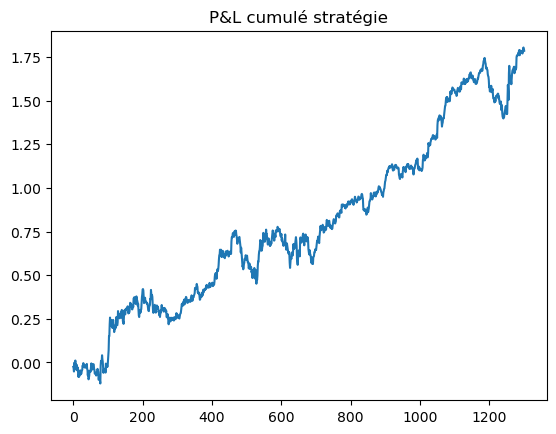

In [372]:
import numpy as np

# vos vecteurs (de même longueur)
# preds  = np.array([...])  # vos returns prédits
# reals  = np.array([...])  # vos returns réels

# 1) Définir la position prise chaque jour : +1 si on prévoit une hausse, –1 si une baisse
# preds = pred[:,0]
# reals = np.array(yte)[:,0]
preds = pred
reals = np.array(yte)
positions = np.sign(preds)

# 2) Calculer les profits journaliers de la stratégie
#    (position × return réalisé)
strat_ret = positions * reals

# 3) P&L cumulé
pnl_cum = np.cumsum(strat_ret)

# 4) P&L total
total_pnl = pnl_cum[-1]
print(f"P&L total de la stratégie : {total_pnl:.4f}")

# 5) Sharpe ratio
#    on considère ici un rendement sans risque nul et des données journalières
annual_factor = np.sqrt(252)  
sharpe = np.mean(strat_ret) / np.std(strat_ret) * annual_factor
print(f"Sharpe ratio annualisé : {sharpe:.4f}")
rf_annual = 0.03

# on convertit en rendement journalier composé :
rf_daily = (1 + rf_annual)**(1/252) - 1  

# vos retours de stratégie journaliers :
strat_ret = positions * reals  

# excès de rendement : stratégie moins le RF quotidien
excess_ret = strat_ret - rf_daily  

# Sharpe annualisé corrigé :
sharpe_corrected = (np.mean(excess_ret) / np.std(excess_ret)) * np.sqrt(252)

print(f"Sharpe annualisé (avec RF={rf_annual*100:.1f}%): {sharpe_corrected:.2f}")
# (optionnel) pour visualiser le P&L cumulé :
import matplotlib.pyplot as plt
plt.plot(pnl_cum)
plt.title("P&L cumulé stratégie")
plt.show()


In [ ]:
corr_df.head(30)

,pearson,spearman,kendall,max_abs_corr
XOM_ema3,0.071439,0.034680,0.023775,0.071439
XOM_ema6,0.059502,0.034128,0.023500,0.059502
BAC_ema3,0.049278,0.007183,0.004473,0.049278
WMT_ema6,0.047907,0.019777,0.013327,0.047907
XOM_ema12,0.047621,0.028782,0.019506,0.047621
BAC_ema6,0.046247,0.002568,0.001695,0.046247
WMT_ema12,0.044591,0.016266,0.010677,0.044591
JNJ_ema3,0.044202,0.000446,0.000154,0.044202
WMT_ema3,0.044094,0.015353,0.010286,0.044094
JPM_ema3,0.042756,0.005132,0.003311,0.042756


In [ ]:
x = df_all['XOM_ema3'] - df_all['XOM_ema6']
# For x > +0.005 subtract threshold, for x < -0.005 add threshold, else zero
signal = np.where(x >  0.005, x - 0.005,np.where(x < -0.005, x + 0.005,0))

# 13) Build final DataFrame of signals
final = pd.DataFrame(index=df_all.index)
final['signal_XOM_diff'] = signal
final = final.fillna(0)
print("Preview of 'final' DataFrame with signals:")
print(final.head())

# 14) Prediction using signal feature
# Prepare X and y
df_pred = final.copy()
df_pred['target'] = df_all['target']
X = df_pred[['signal_XOM_diff']].values
y = df_pred['target'].fillna(0).values

# Train/test split (70% train, 30% test)
split_idx = int(len(df_pred) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Define models to evaluate
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=0.1),
    'Lasso': Lasso(alpha=0.1),
    'RF': RandomForestRegressor(n_estimators=100, random_state=42),
    'GB': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    results[name] = score

print("R2 scores for models predicting AAPL next-day return using XOM signal feature:")
print(results)


Preview of 'final' DataFrame with signals:
            signal_XOM_diff
Date                       
2004-09-20         0.000000
2004-09-21         0.000000
2004-09-22         0.000000
2004-09-23        -0.001729
2004-09-24         0.000000
R2 scores for models predicting AAPL next-day return using XOM signal feature:
{'Linear': -0.002550325847173962, 'Ridge': 0.001982475803328221, 'Lasso': -0.00020885047250063238, 'RF': -0.18385101100809953, 'GB': -0.10672005635861437, 'SVR': -0.2555463384578138, 'KNN': -0.09985984391545744}


In [36]:
df_pred.isna().sum()

signal_XOM_diff    0
target             1
dtype: int64

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from scipy.stats import spearmanr, kendalltau
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import plotly.graph_objs as go

# 1) Tickers
sp500_sample = ['AAPL','MSFT','GOOGL','AMZN','JPM','BAC','WMT','XOM','JNJ']

# 2) Period
date_start = datetime(1990,1,1)
date_end   = datetime.today()

# 3) Download Stooq data
def download_stooq(tickers, start, end):
    frames = []
    for t in tickers:
        try:
            df = pdr.DataReader(t, 'stooq', start, end).sort_index()
            df.columns = pd.MultiIndex.from_product([[t], df.columns])
            frames.append(df)
        except Exception as e:
            print(f"Error downloading {t}: {e}")
    return pd.concat(frames, axis=1)

raw = download_stooq(sp500_sample, date_start, date_end)

# 4) Daily features (for weekly aggregation)
close_daily = raw.xs('Close', axis=1, level=1)
rets_daily  = close_daily.pct_change().dropna()
W = 21  # daily rolling window for correlations

daily_feats = []
for t in sp500_sample:
    r = rets_daily[t]
    daily_feats.append(pd.DataFrame({
        f"{t}_roll_mean": r.rolling(W).mean(),
        f"{t}_roll_var":  r.rolling(W).var(),
        f"{t}_roll_skew": r.rolling(W).skew()
    }))
base = rets_daily['AAPL']
corrs = []
for t in sp500_sample:
    if t == 'AAPL': continue
    r = rets_daily[t]
    corrs.append(pd.DataFrame({
        f"AAPL_{t}_pear":  base.rolling(W).corr(r),
        f"AAPL_{t}_spear": base.rolling(W).apply(lambda w: spearmanr(w, r.loc[w.index])[0], raw=False),
        f"AAPL_{t}_kend":  base.rolling(W).apply(lambda w: kendalltau(w, r.loc[w.index])[0], raw=False)
    }))
weekly_daily = pd.concat(daily_feats + corrs, axis=1).dropna().resample('W-FRI').mean()

# 5) Weekly returns and base features
weekly_close = close_daily.resample('W-FRI').last().dropna()
rets_w       = weekly_close.pct_change().dropna()

# cross-sectional features
eps      = 1e-6
mean_ret = rets_w.mean(axis=1)
signs    = rets_w.apply(np.sign)
ratios   = rets_w.div(mean_ret+eps, axis=0).add_suffix('_ratio_mean')
gm       = ((1+rets_w).prod(axis=1)**(1/len(sp500_sample)) - 1).rename('gm_ret')
norms    = rets_w.apply(lambda row: np.linalg.norm(row), axis=1).rename('norm_ret')

# 6) Weekly classic time-series features
lags   = [rets_w.shift(lag).add_suffix(f'_lag{lag}') for lag in [1,2,3]]
roll3  = rets_w.rolling(3).std().add_suffix('_vol3')
mom3   = rets_w.rolling(3).mean().add_suffix('_mom3')

# 7) Additional technical and calendar features
# 7a) EMA and MACD
ema_periods = [3,6,12]
ema_feats = []
for p in ema_periods:
    ema = weekly_close.ewm(span=p, adjust=False).mean()
    ema_feats.append(ema.pct_change().add_suffix(f'_ema{p}'))

macd = weekly_close.ewm(span=12, adjust=False).mean() - weekly_close.ewm(span=26, adjust=False).mean()
macd_feat = macd.add_suffix('_macd')

# 7b) RSI (14-week)
def compute_rsi(series, period=14):
    delta = series.diff()
    up, down = delta.clip(lower=0), -delta.clip(upper=0)
    ma_up = up.ewm(alpha=1/period, min_periods=period).mean()
    ma_down = down.ewm(alpha=1/period, min_periods=period).mean()
    rsi = 100 - (100 / (1 + ma_up/ma_down))
    return rsi

rsi_feats = weekly_close.apply(lambda col: compute_rsi(col, period=14)).add_suffix('_rsi14')

# 7c) Calendar
cal = pd.DataFrame(index=weekly_close.index)
cal['week_of_year'] = cal.index.isocalendar().week
cal['month'] = cal.index.month

# 8) Macro (forward-fill to weekly)
fred = {
    'FedFunds':'FEDFUNDS','US10Y':'DGS10',
    'CPI':'CPIAUCSL','Unemployment':'UNRATE','PMI':'PMI'
}
macro = pd.DataFrame(index=rets_w.index)
for name, code in fred.items():
    try:
        df = pdr.DataReader(code, 'fred', date_start, date_end)
        df_w = df.resample('W-FRI').last().fillna(method='ffill')
        macro[name] = df_w[code]
    except Exception as e:
        print(f"Warning: could not load {name} ({code}): {e}")
macro_mom1 = macro.pct_change().add_suffix('_mom1')

# 9) Combine all features
features = pd.concat([
    rets_w.add_suffix('_ret'),
    *lags,
    roll3,
    mom3,
    *ema_feats,
    macd_feat,
    rsi_feats,
    cal,
    macro_mom1,
    weekly_daily,
    signs.add_suffix('_sign'),
    ratios,
    gm,
    norms
], axis=1).dropna()

# 10) Targets: next-week price diff
targets = { t: (weekly_close[t].shift(-1) - weekly_close[t]).rename(f"{t}_diff") for t in sp500_sample }

# 11) Split 50/50
total = len(features)
split = int(total * 0.5)
X_tr, X_te = features.iloc[:split], features.iloc[split:]

# 12) Models to evaluate
models = {
    'Ridge': Ridge(alpha=0.1),
    'Lasso': Lasso(alpha=0.1),
    'RF':    RandomForestRegressor(n_estimators=100, random_state=42),
    'GB':    GradientBoostingRegressor(random_state=42),
    'SVR':   SVR(),
    'KNN':   KNeighborsRegressor()
}

# 13) Run experiments
results = pd.DataFrame(index=sp500_sample, columns=models.keys(), dtype=float)
preds_jpm = {}
for t in tqdm(sp500_sample, desc="Tickers"):
    y = targets[t].dropna()
    X_aligned, y_aligned = features.align(y, join='inner', axis=0)
    Xtr, Xte = X_aligned.iloc[:split], X_aligned.iloc[split:]
    ytr, yte = y_aligned.iloc[:split], y_aligned.iloc[split:]
    for name, mdl in models.items():
        pipe = Pipeline([('scaler', StandardScaler()), ('model', mdl)])
        pipe.fit(Xtr, ytr)
        y_pred = pipe.predict(Xte)
        results.loc[t, name] = pipe.score(Xte, yte)
        if t == 'JPM':
            preds_jpm[name] = (yte, y_pred)

# 14) Best model for JPM
best = results.loc['JPM'].idxmax()
y_true, y_pred = preds_jpm[best]

# 15) Plot actual vs predicted
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_true.index, y=y_true, mode='lines', name='JPM Actual'))
fig.add_trace(go.Scatter(x=y_true.index, y=y_pred, mode='lines', name=f'JPM Pred ({best})'))
fig.update_layout(
    title=f"JPM Actual vs Predicted ({best}), R2={results.loc['JPM', best]:.3f}",
    xaxis_title='Date',
    yaxis_title='Weekly Return Diff'
)
fig.show()

# 16) Results table
print("R2 per asset and model:")
print(results)


Response Text:
b'<!DOCTYPE html>\r\n<html lang="en">\r\n<head>\r\n    <meta charset="utf-8">\r\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\r\n    <meta name="viewport" content="width=device-width, initial-scale=1">\r\n    <title>Error - St. Louis Fed</title>\r\n    <meta name="description" content="">\r\n    <meta name="keywords" content="">    \r\n    <link rel="stylesheet" type="text/css" href="/assets/bootstrap/dist/css/bootstrap.min.css">\r\n    <link rel="stylesheet" type="text/css" href="/css/home.min.css?1553087253">\r\n    <link rel="stylesheet" type="text/css" href="/assets/fontawesome-free/css/all.min.css">\r\n    <link rel="stylesheet" type="text/css" href="/assets/select2/dist/css/select2.min.css">\r\n    <style>p {\r\n        margin-bottom: 1.5em;\r\n    }</style>\r\n</head>\r\n<body>\r\n<link rel="preconnect" href="https://fonts.googleapis.com">\n<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>\n<link href="https://fonts.googleapis.com/c

Tickers: 100%|██████████| 9/9 [01:24<00:00,  9.37s/it]


R2 per asset and model:
           Ridge     Lasso        RF        GB       SVR       KNN
AAPL   -0.121547 -0.003563 -0.013143 -0.008305 -0.001199 -0.003520
MSFT   -1.141252 -0.010318 -0.022858 -0.014182 -0.009871 -0.002545
GOOGL  -0.076770 -0.003320 -0.006113 -0.014790 -0.004221 -0.000787
AMZN   -0.041351 -0.004316 -0.007890 -0.010706 -0.006011 -0.012338
JPM    -0.672724 -0.003788  0.000862 -0.012975 -0.003230 -0.000172
BAC   -30.428794 -0.140241 -0.414723 -0.392273 -0.003609 -0.070611
WMT    -2.355600 -0.007873 -0.015672 -0.019512 -0.011342 -0.026751
XOM    -3.499312  0.007939 -0.015936 -0.086116  0.002429 -0.017517
JNJ    -4.313854 -0.002057 -0.019124 -0.072778 -0.000520 -0.030470


In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBRegressor
import itertools
import plotly.graph_objs as go

# 1) Configuration
domain_series = {
    'economic': ['GDP','GDPC1','CPIAUCSL','PCEPI','UNRATE','PAYEMS','INDPRO','USSLIND','NETEXP'],
    'credit':   ['FEDFUNDS','DFF','TB3MS','DGS10','DGS2','T10Y3M','T10Y2Y','TEDRATE'],
    'commod':   ['DCOILWTICO','DCOILBRENTEU','PCOPPUSDM','GOLDAMGBD228NLBM'],
    'currency':['DEXUSAL','DEXJPUS'],'volatility':['VIXCLS'],
    'sentiment':['UMCSENT','CSCICP03'],'survey':['NAPM','DGORDER']
}
tech_tickers = ['AAPL','MSFT','GOOGL','AMZN']
financial_tickers = ['JPM','BAC']
consumer_tickers = ['WMT','XOM','JNJ']
sp500_sample = tech_tickers + financial_tickers + consumer_tickers

date_start, date_end = datetime(1990,1,1), datetime.today()

# 2) Download prices
def download_stooq(tickers, start, end):
    frames = []
    for t in tickers:
        try:
            df = pdr.DataReader(t, 'stooq', start, end).sort_index()
            df.columns = pd.MultiIndex.from_product([[t], df.columns])
            frames.append(df)
        except Exception:
            pass
    return pd.concat(frames, axis=1)

raw = download_stooq(sp500_sample, date_start, date_end)
close_daily = raw.xs('Close', axis=1, level=1)

# 3) Monthly sample & returns
monthly_index = close_daily.resample('M').last().ffill().index
close_sample = close_daily.reindex(monthly_index, method='ffill')
rets = close_sample.pct_change().dropna()

# 4) Technical indicators
tech_feats = pd.DataFrame(index=rets.index)
for t in sp500_sample:
    price = close_sample[t]
    delta = price.diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = (-delta.clip(upper=0)).rolling(14).mean()
    rs = gain / loss
    tech_feats[f"{t}_RSI"] = 100 - 100 / (1 + rs)
    ema12 = price.ewm(span=12).mean()
    ema26 = price.ewm(span=26).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9).mean()
    tech_feats[f"{t}_MACD"] = macd
    tech_feats[f"{t}_MACD_sig"] = signal
tech_feats.fillna(method='ffill', inplace=True)

# 5) Macro features sampled monthly
macro_dfs = []
for domain, ticks in domain_series.items():
    series_list = []
    for s in ticks:
        try:
            df = pdr.DataReader(s, 'fred', date_start, date_end)
            series_list.append(df.rename(columns={s: s}))
        except Exception:
            pass
    if series_list:
        macro = pd.concat(series_list, axis=1) \
                  .resample('M').ffill() \
                  .reindex(monthly_index).fillna(0)
        feats = pd.DataFrame(index=monthly_index)
        for c in macro.columns:
            feats[f"{c}_lvl"] = macro[c]
            feats[f"{c}_1m"] = macro[c].pct_change(1)
            feats[f"{c}_3m"] = macro[c].pct_change(3)
        macro_dfs.append(feats)

# 6) Combine features & interactions per domain
dfs = macro_dfs + [tech_feats]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
feat_list = []
for df in dfs:
    if df.shape[0] == 0:
        continue
    df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()
    if df_clean.shape[0] == 0:
        continue
    inter = poly.fit_transform(df_clean)
    cols = poly.get_feature_names_out(df_clean.columns)
    feat_list.append(pd.DataFrame(inter, index=df_clean.index, columns=cols))

# 7) Date features
dates = pd.DataFrame(index=monthly_index)
dates['month'] = dates.index.month
dates['year'] = dates.index.year
date_feats = pd.get_dummies(
    dates,
    prefix=['m', 'y'],
    columns=['month', 'year'],
    drop_first=True
)

# 8) Assemble all features
X_full = pd.concat(feat_list + [date_feats], axis=1).dropna()

# 9) Cross interactions of top global drivers
i1, i2 = int(len(X_full) * 0.3), int(len(X_full) * 0.7)
importances = pd.DataFrame(index=X_full.columns)
for t in sp500_sample:
    y = rets[t].reindex(X_full.index).dropna()
    X_aligned, y_aligned = X_full.align(y, 'inner', axis=0)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_aligned.iloc[:i1], y_aligned.iloc[:i1])
    importances[t] = pd.Series(rf.feature_importances_, index=X_full.columns)

avg_imp = importances.mean(axis=1).nlargest(20).index
top_pairs = list(itertools.combinations(avg_imp, 2))
for f1, f2 in top_pairs:
    X_full[f"{f1}_x_{f2}"] = X_full[f1] * X_full[f2]

# 10) Normalization & selection
pt = PowerTransformer()
X_norm = pd.DataFrame(pt.fit_transform(X_full),
                      index=X_full.index,
                      columns=X_full.columns)
selector = SelectKBest(f_regression, k=50)
y_ref = (
    rets[['AAPL', 'MSFT']]
    .resample('M')
    .last()
    .reindex(X_norm.index)
    .dropna()
    .mean(axis=1)
)
X_sel = pd.DataFrame(
    selector.fit_transform(X_norm, y_ref),
    index=X_norm.index,
    columns=[c for c, m in zip(X_norm.columns, selector.get_support()) if m]
)

# 11) KernelPCA
ekpca = KernelPCA(n_components=25, kernel='rbf', gamma=0.5)
X_kpca = pd.DataFrame(
    ekpca.fit_transform(X_sel),
    index=X_sel.index,
    columns=[f'KPCA{i+1}' for i in range(25)]
)

# 12) Targets (monthly adj diff)
baseline = rets.shift(1)
targets = {
    t: (rets[t] - baseline[t]).rename(f"{t}_m_diff_adj")
    for t in sp500_sample
}

# 13) Train/test split
i1, i2 = int(len(X_kpca) * 0.3), int(len(X_kpca) * 0.7)

# 14) Models & tuning
cv = TimeSeriesSplit(5)
ridge_cv = GridSearchCV(Ridge(), {'alpha': [0.01, 0.1, 1]}, cv=cv)
rf_cv = GridSearchCV(
    RandomForestRegressor(random_state=42),
    {'n_estimators': [100, 200], 'max_depth': [5, 10]},
    cv=cv
)
xgb_cv = GridSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]},
    cv=cv
)
estimators = [('ridge', ridge_cv), ('rf', rf_cv), ('xgb', xgb_cv)]
stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
models = {'Stack': stack, 'SVR': SVR(), 'KNN': KNeighborsRegressor()}

# 15) Backtest R2
results = pd.DataFrame(index=sp500_sample, columns=models.keys())
preds = {}
for t in sp500_sample:
    y = targets[t].reindex(X_kpca.index).dropna()
    X_al, y_al = X_kpca.align(y, 'inner', axis=0)
    X_tr, X_val = X_al.iloc[:i1], X_al.iloc[i1:i2]
    y_tr, y_val = y_al.iloc[:i1], y_al.iloc[i1:i2]
    preds[t] = {}
    for name, mdl in models.items():
        mdl.fit(X_tr, y_tr)
        results.loc[t, name] = mdl.score(X_val, y_val)
        if t == 'AAPL':
            preds[name] = (y_val, mdl.predict(X_val))

print(results)

# 16) Plot AAPL
best = results.loc['AAPL'].idxmax()
yt, yp = preds['Stack']
fig = go.Figure()
fig.add_trace(go.Scatter(x=yt.index, y=yt, mode='lines', name='real'))
fig.add_trace(go.Scatter(x=yt.index, y=yp, mode='lines', name='pred'))
fig.update_layout(
    title=f'AAPL Monthly ({best})',
    xaxis_title='Date',
    yaxis_title='Adj diff'
)
fig.show()


In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from scipy.stats import spearmanr, kendalltau
from tqdm import tqdm
import plotly.graph_objs as go

# 1) Configuration
domain_series = {
    'economic': ['GDP','GDPC1','CPIAUCSL','PCEPI','UNRATE','PAYEMS','INDPRO','USSLIND','NETEXP'],
    'credit':   ['FEDFUNDS','DFF','TB3MS','DGS10','DGS2','T10Y3M','T10Y2Y','TEDRATE'],
    'commod':   ['DCOILWTICO','DCOILBRENTEU','PCOPPUSDM','GOLDAMGBD228NLBM'],
    'currency': ['DEXUSAL','DEXJPUS'],
    'volatility':['VIXCLS'],
    'sentiment':['UMCSENT','CSCICP03'],
    'survey':   ['NAPM','DGORDER']
}
tech_tickers = ['AAPL','MSFT','GOOGL','AMZN']
financial_tickers = ['JPM','BAC']
consumer_tickers = ['WMT','XOM','JNJ']
sp500_sample = tech_tickers + financial_tickers + consumer_tickers

date_start, date_end = datetime(1990,1,1), datetime.today()

def download_stooq(tickers, start, end):
    """
    Télécharge les données OHLC pour chaque ticker via Stooq sur la période donnée.
    Retourne un DataFrame concaténé avec un MultiIndex (ticker, OHLC).
    """
    frames = []
    for t in tickers:
        try:
            df = pdr.DataReader(t, 'stooq', start, end).sort_index()
            df.columns = pd.MultiIndex.from_product([[t], df.columns])
            frames.append(df)
        except Exception as e:
            print(f"Erreur téléchargement {t}: {e}")
    if not frames:
        raise ValueError("Aucun ticker téléchargé depuis Stooq.")
    return pd.concat(frames, axis=1)

# 2) Sample tous les 5 jours et returns les 5 jours et returns
market_days = close_daily.index
sample_days = market_days[::5]
close_sample = close_daily.reindex(sample_days,method='ffill')
rets = close_sample.pct_change().dropna()

# 3) Indicateurs techniques (RSI, MACD) pour chaque ticker
tech_feats = pd.DataFrame(index=rets.index)
for t in sp500_sample:
    price = close_sample[t]
    delta = price.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain/avg_loss
    tech_feats[f"{t}_RSI"] = 100 - (100/(1+rs))
    ema12 = price.ewm(span=12,adjust=False).mean()
    ema26 = price.ewm(span=26,adjust=False).mean()
    macd = ema12-ema26
    signal = macd.ewm(span=9,adjust=False).mean()
    tech_feats[f"{t}_MACD"] = macd
    tech_feats[f"{t}_MACD_sig"] = signal
tech_feats.fillna(method='ffill', inplace=True)

# 4) Macro features domain_series (as before, sampled on sample_days)
macro_frames = []
for domain, ticks in domain_series.items():
    df_list = []
    for t in ticks:
        try:
            df = pdr.DataReader(t, 'fred', date_start, date_end)
            df_list.append(df.rename(columns={t: t}))
        except Exception:
            pass
    if df_list:
        macro = pd.concat(df_list, axis=1)
        # Sample on the same sample_days grid
        macro = macro.reindex(sample_days, method='ffill').fillna(0)
        feats = pd.DataFrame(index=sample_days)
        for col in macro.columns:
            feats[f"{col}_lvl"] = macro[col]
            feats[f"{col}_1m"] = macro[col].pct_change(periods=5)
            feats[f"{col}_3m"] = macro[col].pct_change(periods=15)
        macro_frames.append((domain, feats.fillna(0)))

# 5) Combine domain features + tech_feats with interactions with interactions
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
domain_feature_dfs = [df for _,df in macro_frames] + list(domains_feat.values()) + [tech_feats]
feature_dfs = []
for feats in domain_feature_dfs:
    feats = feats.replace([np.inf,-np.inf],np.nan).dropna()
    inter = poly.fit_transform(feats)
    cols = poly.get_feature_names_out(feats.columns)
    feature_dfs.append(pd.DataFrame(inter,index=feats.index,columns=cols))

# 6) Date dummies
dates = pd.DataFrame(index=sample_days)
dates['day']=dates.index.weekday
dates['week']=dates.index.isocalendar().week
day_dummies=pd.get_dummies(dates['day'],prefix='dow')
week_dummies=pd.get_dummies(dates['week'],prefix='w')
date_dummies=pd.concat([day_dummies,week_dummies],axis=1)

# 7) Assemble all features
X_all = pd.concat(feature_dfs + [date_dummies], axis=1).dropna()

# 8) Cross features on top correlated with AAPL target (avoid forward bias using validation set)
import itertools
# Align features and AAPL target
y_aapl = targets['AAPL'].reindex(X_all.index).dropna()
X_aapl, y_aapl = X_all.align(y_aapl, join='inner', axis=0)
# Identify validation slice indices i1,i2
i1, i2 = int(len(X_all)*0.3), int(len(X_all)*0.7)
X_val = X_aapl.iloc[i1:i2]
y_val = y_aapl.iloc[i1:i2]
# Compute absolute Pearson correlation on validation
corrs = X_val.corrwith(y_val).abs()
# Select top 20 features
top_feats = corrs.sort_values(ascending=False).head(20).index.tolist()
# Create pairwise interactions among top features
for f1, f2 in itertools.combinations(top_feats, 2):
    X_all[f"{f1}_x_{f2}"] = X_all[f1] * X_all[f2]

# 9) Power transform normalization normalization
pt = PowerTransformer(method='yeo-johnson')
X_norm = pd.DataFrame(pt.fit_transform(X_all), index=X_all.index, columns=X_all.columns)

# 9) Feature selection: univariate select top 50
from sklearn.feature_selection import SelectKBest, f_regression
# Use AAPL target for scoring
y_ref = targets[sp500_sample[0]].reindex(X_norm.index).dropna()
X_norm_aligned, y_ref = X_norm.align(y_ref, join='inner', axis=0)
selector = SelectKBest(score_func=f_regression, k=50)
X_sel = pd.DataFrame(selector.fit_transform(X_norm_aligned, y_ref),
                     index=X_norm_aligned.index,
                     columns=[col for col,mask in zip(X_norm_aligned.columns, selector.get_support()) if mask])

# 10) Kernel PCA on selected features
kpca = KernelPCA(n_components=25, kernel='rbf', gamma=1.0, fit_inverse_transform=False)
X_kpca = kpca.fit_transform(X_sel)
X_all = pd.DataFrame(X_kpca, index=X_sel.index, columns=[f'KPCA{i+1}' for i in range(25)])

# 11) Targets adjusted (unchanged)
baseline = rets.rolling(1).mean().shift(1)
# 11) Targets adjusted (unchanged)
baseline = rets.rolling(1).mean().shift(1)
targets = {t: (rets[t] - baseline[t]).rename(f"{t}_5d_diff_adj") for t in sp500_sample}

# 12) Train/test split
baseline = rets.rolling(1).mean().shift(1)
targets={t:(rets[t]-baseline[t]).rename(f"{t}_5d_diff_adj") for t in sp500_sample}

# 11) Train/test split
i1, i2 = int(len(X_all)*0.3), int(len(X_all)*0.7)

# 12) Model definitions with hyperparam tuning
from xgboost import XGBRegressor
# Set up parameter grids for RF, GB, XGB
rf_cv = GridSearchCV(RandomForestRegressor(random_state=42),
                     param_grid={'n_estimators':[100,200],'max_depth':[5,10]},
                     cv=cv)
gb_cv = GridSearchCV(GradientBoostingRegressor(random_state=42),
                     param_grid={'n_estimators':[100,200],'learning_rate':[0.01,0.1]},
                     cv=cv)
xgb_cv = GridSearchCV(XGBRegressor(random_state=42, objective='reg:squarederror'),
                      param_grid={'n_estimators':[100,200],'max_depth':[3,6],'learning_rate':[0.01,0.1]},
                      cv=cv)
estimators = [
    ('ridge', ridge_cv),
    ('lasso', lasso_cv),
    ('rf', rf_cv),
    ('gb', gb_cv),
    ('xgb', xgb_cv)
]
stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
models = {
    'Stack': stack,
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

# 13) Backtest R2
results=pd.DataFrame(index=sp500_sample,columns=models.keys(),dtype=float)
preds={}
for t in tqdm(sp500_sample):
    y=targets[t].reindex(X_all.index).dropna()
    X,y=X_all.align(y,'inner',axis=0)
    X_tr,X_val=X.iloc[:i1],X.iloc[i1:i2]
    y_tr,y_val=y.iloc[:i1],y.iloc[i1:i2]
    for name,mdl in models.items():
        mdl.fit(X_tr,y_tr)
        results.loc[t,name]=mdl.score(X_val,y_val)
        if t=='AAPL': preds[name]=(y_val,mdl.predict(X_val))

print(results)
# 14) Plot best AAPL
best=results.loc['AAPL'].idxmax()
yt,yp=preds[best]
fig=go.Figure();fig.add_trace(go.Scatter(x=yt.index,y=yt,mode='lines',name='real'));fig.add_trace(go.Scatter(x=yt.index,y=yp,mode='lines',name='pred'))
fig.update_layout(title=f'AAPL best {best}',xaxis_title='Date',yaxis_title='Diff')
fig.show()


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from scipy.stats import spearmanr, kendalltau
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import plotly.graph_objs as go
from IPython.display import display

# 1) Tickers
sp500_sample = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JPM', 'BAC', 'WMT', 'XOM', 'JNJ']

# 2) Période
date_start = datetime(1990, 1, 1)
date_end = datetime.today()

# 3) Téléchargement Stooq (original)
def download_stooq(tickers, start, end):
    frames = []
    for t in tickers:
        try:
            df = pdr.DataReader(t, 'stooq', start, end).sort_index()
            df.columns = pd.MultiIndex.from_product([[t], df.columns])
            frames.append(df)
        except Exception as e:
            print(f"Erreur téléchargement {t}: {e}")
    return pd.concat(frames, axis=1)

raw = download_stooq(sp500_sample, date_start, date_end)

# 4) Features journalières
close_daily = raw.xs('Close', axis=1, level=1)
rets_daily = close_daily.pct_change().dropna()
W_days = 21

daily_feats = []
for t in tqdm(sp500_sample, desc="Compute Daily Stats"):
    r = rets_daily[t]
    daily_feats.append(pd.DataFrame({
        f"{t}_roll_mean": r.rolling(W_days).mean(),
        f"{t}_roll_var":  r.rolling(W_days).var(),
        f"{t}_roll_skew": r.rolling(W_days).skew()
    }))

# 4b) corrélations journalières
pairs = [(i, j) for idx, i in enumerate(sp500_sample) for j in sp500_sample[idx+1:]]
corr_daily_feats = []
for i, j in tqdm(pairs, desc="Daily Pair Corrs"):
    ri, rj = rets_daily[i], rets_daily[j]
    corr_daily_feats.append(pd.DataFrame({
        f"{i}/{j}_pear": ri.rolling(W_days).corr(rj),
        f"{i}/{j}_spearman": ri.rolling(W_days).apply(
            lambda w: spearmanr(w, rj.loc[w.index])[0], raw=False),
        f"{i}/{j}_kendall": ri.rolling(W_days).apply(
            lambda w: kendalltau(w, rj.loc[w.index])[0], raw=False)
    }))

# 5) Agrégation journalière -> mensuelle
daily_features = pd.concat(daily_feats + corr_daily_feats, axis=1).dropna()
monthly_daily = daily_features.resample('M').mean()

# 6) Rendements mensuels
monthly_close = close_daily.resample('M').last()
rets_m = monthly_close.pct_change().dropna()

# 7) Cross-features mensuelles
eps = 1e-6
mean_ret = rets_m.mean(axis=1)
signs = rets_m.apply(np.sign)
ratios = rets_m.div(mean_ret + eps, axis=0).add_suffix('_ratio_mean')

_df_prod = []
for i, j in tqdm(pairs, desc="Pair Products"):
    _df_prod.append((rets_m[i] * rets_m[j]).rename(f"{i}_{j}_prod"))

W_months = 12
_df_kend_rolling = []
for i, j in tqdm(pairs, desc="12m Kendalls"):
    df_kend = rets_m[i].rolling(W_months).apply(
        lambda w: kendalltau(w, rets_m[j].loc[w.index])[0], raw=False
    )
    _df_kend_rolling.append(df_kend.rename(f"{i}_{j}_kend_12m"))

# 8) Features mensuelles classiques
lags = [rets_m.shift(lag).add_suffix(f'_lag{lag}') for lag in [1,2,3]]
roll3 = rets_m.rolling(3).std().add_suffix('_vol3')
roll6 = rets_m.rolling(6).std().add_suffix('_vol6')
mom3 = rets_m.rolling(3).mean().add_suffix('_mom3')

# 9) Macro FRED étendues
fred = {
    'FedFunds':'FEDFUNDS', 'US10Y':'DGS10', 'CPI':'CPIAUCSL', 'Unemployment':'UNRATE',
    'M2':'M2SL', 'INDPRO':'INDPRO', 'Sentiment':'UMCSENT', 'TB3MS':'TB3MS'
}
macro = pd.DataFrame(index=rets_m.index)
for name, code in tqdm(fred.items(), desc="Fetch Macro"):
    try:
        dfm = pdr.DataReader(code, 'fred', date_start, date_end)
        dfm = dfm.resample('M').last().fillna(method='ffill')
        macro[name] = dfm[code]
    except Exception:
        pass
macro = macro.fillna(method='ffill').fillna(method='bfill')
macro_mom1 = macro.pct_change().add_suffix('_mom1')

# 10) Concaténation finale
total_features = pd.concat([
    rets_m.add_suffix('_ret'), *lags, roll3, roll6, mom3,
    macro_mom1, monthly_daily, signs.add_suffix('_sign'), ratios,
    *_df_prod, *_df_kend_rolling
], axis=1).dropna()

# 11) Targets
targets = {t: (monthly_close[t].shift(-1) - monthly_close[t]).rename(f"{t}_diff") for t in sp500_sample}

# 12) Split train/test (80/20)
n = len(total_features)
train_cut = int(n * 0.8)

# 13) Modèles factory
def get_models():
    return {
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'RF': RandomForestRegressor(n_estimators=100, random_state=42),
        'GB': GradientBoostingRegressor(random_state=42),
        'SVR': SVR(),
        'KNN': KNeighborsRegressor()
    }
models = get_models()

# 14) Backtest multi-actifs
results = pd.DataFrame(index=sp500_sample, columns=list(models.keys())+['P&L','Sharpe'], dtype=float)
preds_store = {}
for t in tqdm(sp500_sample, desc="Tickers BT"):
    y = targets[t].dropna()
    Xaligned, yaligned = total_features.align(y, join='inner', axis=0)
    Xtr, Xte = Xaligned.iloc[:train_cut], Xaligned.iloc[train_cut:]
    ytr, yte = yaligned.iloc[:train_cut], yaligned.iloc[train_cut:]

    preds_store[t] = {}
    for name, mdl in tqdm(models.items(), desc=f"Models {t}", leave=False):
        pipe = Pipeline([('scaler', StandardScaler()),('model', mdl)])
        pipe.fit(Xtr, ytr)
        y_pred = pipe.predict(Xte)
        results.loc[t, name] = pipe.score(Xte, yte)
        preds_store[t][name] = (yte, y_pred)
    # P&L & Sharpe
    best = results.loc[t, list(models.keys())].astype(float).idxmax()
    ytrue, ypred = preds_store[t][best]
    strat = np.sign(ypred) * ytrue
    results.loc[t, 'P&L'] = strat.cumsum().iloc[-1]
    results.loc[t, 'Sharpe'] = (strat.mean() / (strat.std()+1e-9)) * np.sqrt(12)

# 15) Sélection actifs R2 positif
best_models = results[list(models.keys())].idxmax(axis=1)
pos_assets = [t for t in sp500_sample if results.loc[t, best_models[t]] > 0]

# 16) DataFrame prédictions + MAE rolling (12m)
df_list = []
for t in pos_assets:
    yte, ypred = preds_store[t][best_models[t]]
    df = pd.DataFrame({'true': yte, 'pred': ypred})
    df['mae_12m'] = (df['pred'] - df['true']).abs().rolling(12).mean()
    df.columns = [f"{t}_true", f"{t}_pred", f"{t}_mae_12m"]
    df_list.append(df)

df_pred_mae = pd.concat(df_list, axis=1)

# 17) Construction panier pondéré par moyenne des prix sur 2 ans
avg_prices = monthly_close[pos_assets].tail(24).mean()
weights = avg_prices / avg_prices.sum()
basket_ret = (rets_m[pos_assets] * weights).sum(axis=1).rename('basket_ret')

# alignement features et basket
X_basket, y_basket = total_features.align(basket_ret, join='inner', axis=0)

# découpage 40% train / 40% validation / 20% test
n = len(X_basket)
i1, i2 = int(n*0.4), int(n*0.8)
Xb1, Xb2, Xb3 = X_basket.iloc[:i1], X_basket.iloc[i1:i2], X_basket.iloc[i2:]
yb1, yb2, yb3 = y_basket.iloc[:i1], y_basket.iloc[i1:i2], y_basket.iloc[i2:]

# 18) Fit modèles panier et évaluation
results_basket = pd.DataFrame(index=models.keys(), columns=['R2','P&L','Sharpe'], dtype=float)
preds_basket = {}
for name, mdl in tqdm(models.items(), desc="Basket Models"):
    pipe = Pipeline([('scaler', StandardScaler()), ('model', mdl)])
    pipe.fit(Xb1, yb1)
    yb_pred = pipe.predict(Xb3)
    r2b = pipe.score(Xb3, yb3)
    strat_b = np.sign(yb_pred) * yb3
    pnl_b = strat_b.cumsum().iloc[-1]
    sharpe_b = (strat_b.mean() / (strat_b.std()+1e-9)) * np.sqrt(12)
    results_basket.loc[name] = [r2b, pnl_b, sharpe_b]
    preds_basket[name] = (yb3, yb_pred)

# 19) Affichage PnL/Sharpe/R2 par modèle pour chaque actif
print("=== Performance par actif (R2, P&L, Sharpe) ===")
print(results)

# 20) Graphiques et résultats finals
# Apple réel vs prédit
best_apple = results.loc['AAPL', list(models.keys())].astype(float).idxmax()
y_true_a, y_pred_a = preds_store['AAPL'][best_apple]
fig_a = go.Figure()
fig_a.add_trace(go.Scatter(x=y_true_a.index, y=y_true_a, mode='lines', name='AAPL réel'))
fig_a.add_trace(go.Scatter(x=y_true_a.index, y=y_pred_a, mode='lines', name=f'AAPL prédit ({best_apple})'))
fig_a.update_layout(
    title=f"AAPL réel vs prédit ({best_apple}), R2={results.loc['AAPL', best_apple]:.3f}",
    xaxis_title='Date', yaxis_title='Return diff'
)
fig_a.show()

# Basket réel vs prédit pour le meilleur modèle basket
best_b = results_basket['R2'].astype(float).idxmax()
yb_true, yb_pred = preds_basket[best_b]
fig_b = go.Figure()
fig_b.add_trace(go.Scatter(x=yb_true.index, y=yb_true, mode='lines', name='Basket réel'))
fig_b.add_trace(go.Scatter(x=yb_true.index, y=yb_pred, mode='lines', name=f'Basket prédit ({best_b})'))
fig_b.update_layout(
    title=f"Basket réel vs prédit ({best_b}), R2={results_basket.loc[best_b,'R2']:.3f}",
    xaxis_title='Date', yaxis_title='Return'
)
fig_b.show()

# Affichage df_pred_mae
print("=== Prédictions & MAE rolling (12m) pour actifs R2+ ===")
display(df_pred_mae)

# Affichage résultats basket
print("=== Performance Panier (R2, P&L, Sharpe) ===")
print(results_basket)

def print_results():
    print("DF Prédictions + MAE rolling (12m) pour actifs R2+ :")
    display(df_pred_mae)
    print("\nRésultats basket (R2, P&L, Sharpe) :")
    print(results_basket)

print_results()

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from scipy.stats import spearmanr, kendalltau
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import plotly.graph_objs as go

# 1) Tickers
sp500_sample = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JPM', 'BAC', 'WMT', 'XOM', 'JNJ']

# 2) Période
date_start = datetime(1990, 1, 1)
date_end = datetime.today()

# 3) Téléchargement Stooq avec barre de progression
def download_stooq(tickers, start, end):
    frames = []
    for t in tqdm(tickers, desc="Download Tickers"):
        try:
            df = pdr.DataReader(t, 'stooq', start, end).sort_index()
            df.columns = pd.MultiIndex.from_product([[t], df.columns])
            frames.append(df)
        except Exception as e:
            print(f"Erreur téléchargement {t}: {e}")
    return pd.concat(frames, axis=1)

raw = download_stooq(sp500_sample, date_start, date_end)

# 4) Features journalières
close_daily = raw.xs('Close', axis=1, level=1)
rets_daily = close_daily.pct_change().dropna()
W_days = 21

# 4a) rolling mean/var/skew avec tqdm
daily_feats = []
for t in tqdm(sp500_sample, desc="Compute Daily Stats"):
    r = rets_daily[t]
    daily_feats.append(pd.DataFrame({
        f"{t}_roll_mean": r.rolling(W_days).mean(),
        f"{t}_roll_var": r.rolling(W_days).var(),
        f"{t}_roll_skew": r.rolling(W_days).skew()
    }))

# 4b) Corrélations journalières entre toutes les paires avec tqdm
pairs = [(i, j) for idx, i in enumerate(sp500_sample) for j in sp500_sample[idx+1:]]
corr_daily_feats = []
for i, j in tqdm(pairs, desc="Daily Pair Correlations"):
    ri = rets_daily[i]
    rj = rets_daily[j]
    pear = ri.rolling(W_days).corr(rj)
    spear = ri.rolling(W_days).apply(lambda w: spearmanr(w, rj.loc[w.index])[0], raw=False)
    kend = ri.rolling(W_days).apply(lambda w: kendalltau(w, rj.loc[w.index])[0], raw=False)
    corr_daily_feats.append(pd.DataFrame({
        f"{i}/{j}_pear": pear,
        f"{i}/{j}_spearman": spear,
        f"{i}/{j}_kendall": kend
    }))

daily_features = pd.concat(daily_feats + corr_daily_feats, axis=1).dropna()
monthly_daily = daily_features.resample('M').mean()

# 5) Rendements mensuels
monthly_close = close_daily.resample('M').last()
rets_m = monthly_close.pct_change().dropna()

# 5b) Cross-features mensuelles avec tqdm
eps = 1e-6
mean_ret = rets_m.mean(axis=1)
signs = rets_m.apply(np.sign)
ratios = rets_m.div(mean_ret + eps, axis=0).add_suffix('_ratio_mean')
_df_prod = []
for i, j in tqdm(pairs, desc="Compute Pair Products"):
    _df_prod.append((rets_m[i] * rets_m[j]).rename(f"{i}_{j}_prod"))

# roll Kendall mensuel avec tqdm
W_months = 12
df_kend_rolling = []
for i, j in tqdm(pairs, desc="Compute 12m Kendall"):
    df_kend = rets_m[i].rolling(W_months).apply(
        lambda w: kendalltau(w, rets_m[j].loc[w.index])[0], raw=False
    ).rename(f"{i}_{j}_kend_12m")
    df_kend_rolling.append(df_kend)

# 6) Features mensuelles classiques
lags = [rets_m.shift(lag).add_suffix(f'_lag{lag}') for lag in [1, 2, 3]]
roll3 = rets_m.rolling(3).std().add_suffix('_vol3')
roll6 = rets_m.rolling(6).std().add_suffix('_vol6')
mom3 = rets_m.rolling(3).mean().add_suffix('_mom3')

# 7) Macro données FRED étendues avec tqdm
fred = {
    'FedFunds': 'FEDFUNDS',
    'US10Y': 'DGS10',
    'CPI': 'CPIAUCSL',
    'Unemployment': 'UNRATE',
    'M2': 'M2SL',
    'INDPRO': 'INDPRO',
    'Sentiment': 'UMCSENT',
    'TB3MS': 'TB3MS'
}
macro = pd.DataFrame(index=rets_m.index)
for name, code in tqdm(fred.items(), desc="Fetch Macro FRED"):
    try:
        df = pdr.DataReader(code, 'fred', date_start, date_end)
        dfm = df.resample('M').last().fillna(method='ffill')
        macro[name] = dfm[code]
    except Exception as e:
        print(f"Avertissement : impossible de charger {name} – {e}")
macro = macro.fillna(method='ffill').fillna(method='bfill')
macro_mom1 = macro.pct_change().add_suffix('_mom1')

# 8) Concaténation finale
features = pd.concat([
    rets_m.add_suffix('_ret'),
    *lags,
    roll3, roll6, mom3,
    macro_mom1,
    monthly_daily,
    signs.add_suffix('_sign'),
    ratios,
    *_df_prod,
    *df_kend_rolling
], axis=1).dropna()

# 9) Targets
targets = {t: (monthly_close[t].shift(-1) - monthly_close[t]).rename(f"{t}_diff") for t in sp500_sample}

# 10) Split 80/20
split = int(len(features) * 0.8)

# 11) Modèles
def get_models():
    return {
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'RF': RandomForestRegressor(n_estimators=100, random_state=42),
        'GB': GradientBoostingRegressor(random_state=42),
        'SVR': SVR(),
        'KNN': KNeighborsRegressor()
    }

# 12) Backtest avec tqdm et mesures de performance
results = pd.DataFrame(index=sp500_sample, columns=list(get_models().keys()) + ['P&L', 'Sharpe'], dtype=float)
preds_store = {}
for t in tqdm(sp500_sample, desc="Tickers"):
    y = targets[t].dropna()
    X_aligned, y_aligned = features.align(y, join='inner', axis=0)
    Xtr, Xte = X_aligned.iloc[:split], X_aligned.iloc[split:]
    ytr, yte = y_aligned.iloc[:split], y_aligned.iloc[split:]

    preds_store[t] = {}
    for name, mdl in tqdm(get_models().items(), desc=f"Models {t}", leave=False):
        pipe = Pipeline([('scaler', StandardScaler()), ('model', mdl)])
        pipe.fit(Xtr, ytr)
        y_pred = pipe.predict(Xte)
        results.loc[t, name] = pipe.score(Xte, yte)
        preds_store[t][name] = (yte, y_pred)

    best = results.loc[t, list(get_models().keys())].astype(float).idxmax()
    y_true, y_pred = preds_store[t][best]
    strat_ret = np.sign(y_pred) * y_true
    pnl = strat_ret.cumsum().iloc[-1]
    sharpe = (strat_ret.mean() / (strat_ret.std() + 1e-9)) * np.sqrt(12)
    results.loc[t, 'P&L'] = pnl
    results.loc[t, 'Sharpe'] = sharpe

# 13) Graphique pour Apple
best_apple = results.loc['AAPL', list(get_models().keys())].astype(float).idxmax()
y_true_a, y_pred_a = preds_store['AAPL'][best_apple]
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_true_a.index, y=y_true_a, mode='lines', name='AAPL réel'))
fig.add_trace(go.Scatter(x=y_true_a.index, y=y_pred_a, mode='lines', name=f'AAPL prédit ({best_apple})'))
fig.update_layout(
    title=f"AAPL réel vs prédit ({best_apple}), R2={results.loc['AAPL', best_apple]:.3f}",
    xaxis_title='Date', yaxis_title='Return diff'
)
fig.show()

# 14) Affichage des performances
print("Performances par actif et modèle (R2), P&L et Sharpe :")
print(results)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from scipy.stats import spearmanr, kendalltau
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import plotly.graph_objs as go

# 1) Tickers
sp500_sample = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JPM', 'BAC', 'WMT', 'XOM', 'JNJ']

# 2) Période
date_start = datetime(1990, 1, 1)
date_end = datetime.today()

# 3) Téléchargement Stooq
def download_stooq(tickers, start, end):
    frames = []
    for t in tickers:
        try:
            df = pdr.DataReader(t, 'stooq', start, end).sort_index()
            df.columns = pd.MultiIndex.from_product([[t], df.columns])
            frames.append(df)
        except Exception as e:
            print(f"Erreur téléchargement {t}: {e}")
    return pd.concat(frames, axis=1)

raw = download_stooq(sp500_sample, date_start, date_end)

# 4) Features journalières
close_daily = raw.xs('Close', axis=1, level=1)
rets_daily = close_daily.pct_change().dropna()
W_days = 21

daily_feats = []
for t in sp500_sample:
    r = rets_daily[t]
    daily_feats.append(pd.DataFrame({
        f"{t}_roll_mean": r.rolling(W_days).mean(),
        f"{t}_roll_var": r.rolling(W_days).var(),
        f"{t}_roll_skew": r.rolling(W_days).skew()
    }))

# 4b) Corrélations journalières (rolling) entre toutes les paires
pairs = [(i, j) for idx, i in enumerate(sp500_sample) for j in sp500_sample[idx+1:]]
corr_daily_feats = []
for i, j in pairs:
    ri = rets_daily[i]
    rj = rets_daily[j]
    pear = ri.rolling(W_days).corr(rj)
    spear = ri.rolling(W_days).apply(lambda w: spearmanr(w, rj.loc[w.index])[0], raw=False)
    kend = ri.rolling(W_days).apply(lambda w: kendalltau(w, rj.loc[w.index])[0], raw=False)
    corr_daily_feats.append(pd.DataFrame({
        f"{i}/{j}_pear": pear,
        f"{i}/{j}_spearman": spear,
        f"{i}/{j}_kendall": kend
    }))

daily_features = pd.concat(daily_feats + corr_daily_feats, axis=1).dropna()
monthly_daily = daily_features.resample('M').mean()

# 5) Rendements mensuels
monthly_close = close_daily.resample('M').last()
rets_m = monthly_close.pct_change().dropna()

# 5b) Cross-features sur retours mensuels
eps = 1e-6
mean_ret = rets_m.mean(axis=1)
signs = rets_m.apply(np.sign)
ratios = rets_m.div(mean_ret + eps, axis=0).add_suffix('_ratio_mean')
# produits pour chaque paire
_df_prod = []
for i, j in pairs:
    _df_prod.append((rets_m[i] * rets_m[j]).rename(f"{i}_{j}_prod"))

# roll Kendall sur 12 mois
W_months = 12
df_kend_rolling = []
for i, j in pairs:
    df_kend = rets_m[i].rolling(W_months).apply(
        lambda w: kendalltau(w, rets_m[j].loc[w.index])[0], raw=False
    ).rename(f"{i}_{j}_kend_12m")
    df_kend_rolling.append(df_kend)

# 6) Features mensuelles classiques
lags = [rets_m.shift(lag).add_suffix(f'_lag{lag}') for lag in [1, 2, 3]]
roll3 = rets_m.rolling(3).std().add_suffix('_vol3')
roll6 = rets_m.rolling(6).std().add_suffix('_vol6')
mom3 = rets_m.rolling(3).mean().add_suffix('_mom3')

# 7) Macro données FRED étendues
fred = {
    'FedFunds': 'FEDFUNDS',
    'US10Y': 'DGS10',
    'CPI': 'CPIAUCSL',
    'Unemployment': 'UNRATE',
    'M2': 'M2SL',
    'INDPRO': 'INDPRO',
    'Sentiment': 'UMCSENT',
    'TB3MS': 'TB3MS'
}
macro = pd.DataFrame(index=rets_m.index)
for name, code in fred.items():
    try:
        df = pdr.DataReader(code, 'fred', date_start, date_end)
        dfm = df.resample('M').last().fillna(method='ffill')
        macro[name] = dfm[code]
    except Exception as e:
        print(f"Avertissement : impossible de charger {name} – {e}")
macro = macro.fillna(method='ffill').fillna(method='bfill')
macro_mom1 = macro.pct_change().add_suffix('_mom1')

# 8) Concaténation finale
features = pd.concat([
    rets_m.add_suffix('_ret'),
    *lags,
    roll3, roll6, mom3,
    macro_mom1,
    monthly_daily,
    signs.add_suffix('_sign'),
    ratios,
    *_df_prod,
    *df_kend_rolling
], axis=1).dropna()

# 9) Targets
targets = {t: (monthly_close[t].shift(-1) - monthly_close[t]).rename(f"{t}_diff") for t in sp500_sample}

# 10) Split 80/20
split = int(len(features) * 0.8)

# 11) Modèles
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'RF': RandomForestRegressor(n_estimators=100, random_state=42),
    'GB': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

# 12) Backtest avec tqdm et mesures de performance
results = pd.DataFrame(index=sp500_sample, columns=list(models.keys()) + ['P&L', 'Sharpe'], dtype=float)
preds_store = {}
for t in tqdm(sp500_sample, desc="Tickers"):
    y = targets[t].dropna()
    X_aligned, y_aligned = features.align(y, join='inner', axis=0)
    Xtr, Xte = X_aligned.iloc[:split], X_aligned.iloc[split:]
    ytr, yte = y_aligned.iloc[:split], y_aligned.iloc[split:]

    # stockage prédictions par modèle
    preds_store[t] = {}
    for name, mdl in tqdm(models.items(), desc=f"Models {t}", leave=False):
        pipe = Pipeline([('scaler', StandardScaler()), ('model', mdl)])
        pipe.fit(Xtr, ytr)
        y_pred = pipe.predict(Xte)
        # R2
        results.loc[t, name] = pipe.score(Xte, yte)
        preds_store[t][name] = (yte, y_pred)

    # P&L et Sharpe pour le meilleur modèle
    best = results.loc[t, list(models.keys())].astype(float).idxmax()
    y_true, y_pred = preds_store[t][best]
    strat_ret = np.sign(y_pred) * y_true
    pnl = strat_ret.cumsum().iloc[-1]
    sharpe = (strat_ret.mean() / (strat_ret.std() + 1e-9)) * np.sqrt(12)
    results.loc[t, 'P&L'] = pnl
    results.loc[t, 'Sharpe'] = sharpe

# 13) Graphique pour Apple
best_apple = results.loc['AAPL', list(models.keys())].astype(float).idxmax()
y_true_a, y_pred_a = preds_store['AAPL'][best_apple]
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_true_a.index, y=y_true_a, mode='lines', name='AAPL réel'))
fig.add_trace(go.Scatter(x=y_true_a.index, y=y_pred_a, mode='lines', name=f'AAPL prédit ({best_apple})'))
fig.update_layout(
    title=f"AAPL réel vs prédit ({best_apple}), R2={results.loc['AAPL', best_apple]:.3f}",
    xaxis_title='Date', yaxis_title='Return diff'
)
fig.show()

# 14) Affichage des performances
print("Performances par actif et modèle (R2), P&L et Sharpe :")
print(results)


In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from scipy.stats import spearmanr, kendalltau
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import plotly.graph_objs as go

# 1) Tickers
sp500_sample = ['AAPL','MSFT','GOOGL','AMZN','JPM','BAC','WMT','XOM','JNJ']

# 2) Période
date_start = datetime(1990,1,1)
date_end   = datetime.today()

# 3) Téléchargement Stooq
def download_stooq(tickers, start, end):
    frames = []
    for t in tickers:
        try:
            df = pdr.DataReader(t, 'stooq', start, end).sort_index()
            df.columns = pd.MultiIndex.from_product([[t], df.columns])
            frames.append(df)
        except Exception as e:
            print(f"Erreur téléchargement {t}: {e}")
    return pd.concat(frames, axis=1)

raw = download_stooq(sp500_sample, date_start, date_end)

# 4) Features journalières
close_daily = raw.xs('Close', axis=1, level=1)
rets_daily  = close_daily.pct_change().dropna()
W = 21

daily_feats = []
for t in sp500_sample:
    r = rets_daily[t]
    daily_feats.append(pd.DataFrame({
        f"{t}_roll_mean": r.rolling(W).mean(),
        f"{t}_roll_var":  r.rolling(W).var(),
        f"{t}_roll_skew": r.rolling(W).skew()
    }))

base = rets_daily['AAPL']
corrs = []
for t in sp500_sample:
    if t=='AAPL': continue
    r = rets_daily[t]
    pear = base.rolling(W).corr(r)
    spr  = base.rolling(W).apply(lambda win: spearmanr(win, r.loc[win.index])[0], raw=False)
    ken  = base.rolling(W).apply(lambda win: kendalltau(win,    r.loc[win.index])[0], raw=False)
    corrs.append(pd.DataFrame({
        f"AAPL_{t}_pear":  pear,
        f"AAPL_{t}_spear": spr,
        f"AAPL_{t}_kend":  ken
    }))

daily_features = pd.concat(daily_feats + corrs, axis=1).dropna()
monthly_daily  = daily_features.resample('M').mean()

# 5) Rendements mensuels
monthly_close = close_daily.resample('M').last()
rets_m        = monthly_close.pct_change().dropna()

# 5b) Cross-features
eps      = 1e-6
mean_ret = rets_m.mean(axis=1)
signs    = rets_m.apply(np.sign)
ratios   = rets_m.div(mean_ret+eps, axis=0).add_suffix('_ratio_mean')
gm       = ((1+rets_m).prod(axis=1)**(1/len(sp500_sample)) - 1).rename('gm_ret')
norms    = rets_m.apply(lambda row: np.linalg.norm(row), axis=1).rename('norm_ret')

# 6) Features mensuelles classiques
lags   = [rets_m.shift(lag).add_suffix(f'_lag{lag}') for lag in [1,2,3]]
roll3  = rets_m.rolling(3).std().add_suffix('_vol3')
roll6  = rets_m.rolling(6).std().add_suffix('_vol6')
mom3   = rets_m.rolling(3).mean().add_suffix('_mom3')

# 7) Macro données FRED avec try/except
fred = {
    'FedFunds':'FEDFUNDS','US10Y':'DGS10',
    'CPI':'CPIAUCSL','Unemployment':'UNRATE','PMI':'PMI'
}
macro = pd.DataFrame(index=rets_m.index)
for name, code in fred.items():
    try:
        df = pdr.DataReader(code, 'fred', date_start, date_end)
        dfm = df.resample('M').last().fillna(method='ffill')
        macro[name] = dfm[code]
    except Exception as e:
        print(f"Avertissement : impossible de charger {name} ({code}) – {e}")
# remplir les manquants par propagation
macro = macro.fillna(method='ffill').fillna(method='bfill')
macro_mom1 = macro.pct_change().add_suffix('_mom1')

# 8) Concaténation finale
features = pd.concat([
    rets_m.add_suffix('_ret'),
    *lags,
    roll3, roll6, mom3,
    macro_mom1,
    monthly_daily,
    signs.add_suffix('_sign'),
    ratios,
    gm,
    norms
], axis=1).dropna()

# 9) Targets pour chaque ticker
targets = {
    t: (monthly_close[t].shift(-1) - monthly_close[t]).rename(f"{t}_diff")
    for t in sp500_sample
}

# 10) Split 80/20
split = int(len(features) * 0.5)
X_tr, X_te = features.iloc[:split], features.iloc[split:]

# 11) Modèles à tester
models = {
    'Ridge': Ridge(alpha=0.1),
    'Lasso': Lasso(alpha=0.1),
    'RF':    RandomForestRegressor(n_estimators=100, random_state=42),
    'GB':    GradientBoostingRegressor(random_state=42),
    'SVR':   SVR(),
    'KNN':   KNeighborsRegressor()
}

# 12) Boucle with tqdm
results      = pd.DataFrame(index=sp500_sample, columns=models.keys(), dtype=float)
preds_apple  = {}
coefs_ = []
for t in tqdm(sp500_sample, desc="Tickers"):
    y = targets[t].dropna()
    X, y = features.align(y, join='inner', axis=0)
    Xtr, Xte = X.iloc[:split], X.iloc[split:]
    ytr, yte = y.iloc[:split], y.iloc[split:]
    for name, mdl in models.items():
        pipe = Pipeline([('scaler', StandardScaler()), ('model', mdl)])
        pipe.fit(Xtr, ytr)
        y_pred = pipe.predict(Xte)
        results.loc[t, name] = pipe.score(Xte, yte)
        if t == 'JPM':
            preds_apple[name] = (yte, y_pred)

# 13) Meilleur modèle Apple
best = results.loc['JPM'].idxmax()
y_true, y_pred = preds_apple[best]

# 14) Graphe réel vs prédit pour Apple
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_true.index, y=y_true, mode='lines', name='JPM réel'))
fig.add_trace(go.Scatter(x=y_true.index, y=y_pred, mode='lines',
                        name=f'JPM prédit ({best})'))
fig.update_layout(
    title=f"JPM réel vs prédit ({best}), R2={results.loc['JPM', best]:.3f}",
    xaxis_title='Date',
    yaxis_title='Return diff'
)
fig.show()

# 15) Tableau des R2
print("R2 par actif et modèle :")
print(results)


Avertissement : impossible de charger PMI (PMI) – Unable to read URL: https://fred.stlouisfed.org/graph/fredgraph.csv?id=PMI
Response Text:
b'<!DOCTYPE html>\r\n<html lang="en">\r\n<head>\r\n    <meta charset="utf-8">\r\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\r\n    <meta name="viewport" content="width=device-width, initial-scale=1">\r\n    <title>Error - St. Louis Fed</title>\r\n    <meta name="description" content="">\r\n    <meta name="keywords" content="">    \r\n    <link rel="stylesheet" type="text/css" href="/assets/bootstrap/dist/css/bootstrap.min.css">\r\n    <link rel="stylesheet" type="text/css" href="/css/home.min.css?1553087253">\r\n    <link rel="stylesheet" type="text/css" href="/assets/fontawesome-free/css/all.min.css">\r\n    <link rel="stylesheet" type="text/css" href="/assets/select2/dist/css/select2.min.css">\r\n    <style>p {\r\n        margin-bottom: 1.5em;\r\n    }</style>\r\n</head>\r\n<body>\r\n<link rel="preconnect" href="https://fonts.googl

Tickers: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


R2 par actif et modèle :
          Ridge     Lasso        RF        GB       SVR       KNN
AAPL  -0.008057 -0.014481 -0.012898 -0.005026 -0.016793 -0.031640
MSFT  -0.165597 -0.050017 -0.061155 -0.078659 -0.053188 -0.050989
GOOGL -0.342864 -0.033140 -0.025444 -0.043452 -0.013583 -0.011625
AMZN  -0.222261 -0.019061 -0.020967 -0.030766 -0.019653 -0.024257
JPM   -0.247069 -0.015138 -0.026214 -0.025393 -0.022188 -0.028386
BAC   -2.609097 -0.269160 -0.146849 -0.088637 -0.034382 -0.081831
WMT   -1.142088 -0.047690 -0.044240 -0.020880 -0.070792 -0.070054
XOM   -1.315468 -0.097103 -0.016878 -0.020887 -0.025122 -0.038101
JNJ   -1.194584 -0.048753 -0.003240 -0.005977 -0.012120 -0.048558


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from scipy.stats import spearmanr, kendalltau
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import plotly.graph_objs as go

# 1) Échantillon de tickers
sp500_sample = ['AAPL','MSFT','GOOGL','AMZN','JPM','BAC','WMT','XOM','JNJ']

# 2) Période
date_start = datetime(1990, 1, 1)
date_end   = datetime.today()

# 3) Télécharger OHLCV Stooq pour actions
def download_stooq(tickers, start, end):
    frames = []
    for t in tickers:
        try:
            df = pdr.DataReader(t, 'stooq', start, end).sort_index()
            df.columns = pd.MultiIndex.from_product([[t], df.columns])
            frames.append(df)
        except Exception as e:
            print(f"Erreur téléchargement {t}: {e}")
    return pd.concat(frames, axis=1)

raw = download_stooq(sp500_sample, date_start, date_end)

# 4) Features journalières sur rendements
close_prices_daily = raw.xs('Close', axis=1, level=1)
rets_daily         = close_prices_daily.pct_change().dropna()
roll_window        = 21

# 4a) Rolling mean, var, skew
daily_frames = []
for ticker in sp500_sample:
    r = rets_daily[ticker]
    daily_frames.append(pd.DataFrame({
        f"{ticker}_roll_mean": r.rolling(roll_window).mean(),
        f"{ticker}_roll_var":  r.rolling(roll_window).var(),
        f"{ticker}_roll_skew": r.rolling(roll_window).skew()
    }))

# 4b) Corrélations journalières vs AAPL (Pearson, Spearman, Kendall)
corr_frames = []
base = rets_daily['AAPL']

for ticker in sp500_sample:
    if ticker == 'AAPL':
        continue
    r = rets_daily[ticker]

    # Pearson classique
    pearson = base.rolling(roll_window).corr(r)

    # Spearman = Pearson des rangs
    spearman = base.rolling(roll_window).apply(
        lambda window_vals: spearmanr(
            window_vals,
            r.loc[window_vals.index]
        )[0],
        raw=False
    )

    # Kendall
    kendall = base.rolling(roll_window).apply(
        lambda window_vals: kendalltau(
            window_vals,
            r.loc[window_vals.index]
        )[0],
        raw=False
    )

    corr_frames.append(pd.DataFrame({
        f"AAPL_{ticker}_pearson":  pearson,
        f"AAPL_{ticker}_spearman": spearman,
        f"AAPL_{ticker}_kendall":  kendall
    }))

daily_features      = pd.concat(daily_frames + corr_frames, axis=1).dropna()
monthly_daily_feats = daily_features.resample('M').mean()

# 5) Rendements mensuels
monthly_close = close_prices_daily.resample('M').last()
rets          = monthly_close.pct_change().dropna()

# 6) Features mensuelles traditionnelles
lags = [rets.shift(lag).add_suffix(f'_lag{lag}') for lag in [1,2,3]]
roll_month = pd.concat([
    rets.rolling(3).std().add_suffix('_vol3'),
    rets.rolling(6).std().add_suffix('_vol6'),
    rets.rolling(3).mean().add_suffix('_mom3')
], axis=1).dropna()

# 7) Macro données mensuelles FRED
fred_series = {
    'FedFunds':'FEDFUNDS', 'US10Y':'DGS10',
    'CPI':'CPIAUCSL',    'Unemployment':'UNRATE',
    'PMI':'PMI'
}
macro = pd.DataFrame(index=rets.index)
for name, series in fred_series.items():
    try:
        s = pdr.DataReader(series, 'fred', date_start, date_end)
        m = s.resample('M').last().fillna(method='ffill')
        macro[name] = m[series]
    except Exception as e:
        print(f"Erreur macro {name}: {e}")
macro_ret = macro.pct_change().add_suffix('_mom1').dropna()

# 8) Concat final des features
features = pd.concat([
    rets.add_suffix('_ret'),
    *lags,
    roll_month,
    macro_ret,
    monthly_daily_feats
], axis=1).dropna()

# 9) Target mensuel (différence next month)
target = (
    monthly_close['AAPL'].shift(-1)
    - monthly_close['AAPL']
).rename('AAPL_diff')

# 10) Préparation X, y
Xy = features.join(target).dropna()
X  = Xy.drop(columns=['AAPL_diff'])
y  = Xy['AAPL_diff']

# 11) Pipeline StandardScaler + Ridge
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge',  Ridge(alpha=1.0))
])

# CV backtest
tscv   = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='r2')
print(f"CV samples={len(X)}, R2 Ridge pipeline: {scores.mean():.4f}")

# 12) Split train/test (80/20)
split_idx       = int(len(X) * 0.8)
X_tr, X_te      = X.iloc[:split_idx], X.iloc[split_idx:]
y_tr, y_te      = y.iloc[:split_idx], y.iloc[split_idx:]

# Entraînement final + évaluation
pipeline.fit(X_tr, y_tr)
y_pred = pipeline.predict(X_te)

mse = np.mean((y_te - y_pred) ** 2)
r2  = pipeline.score(X_te, y_te)
print(f"Test samples={len(X_te)}, MSE: {mse:.4f}, R2: {r2:.4f}")

# 13) Visualisation réel vs prédit
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_te.index, y=y_te,   mode='lines', name='réel'))
fig.add_trace(go.Scatter(x=y_te.index, y=y_pred, mode='lines', name='prédit'))
fig.update_layout(
    title='Backtest Monthly - Réel vs Prédit',
    xaxis_title='Date',
    yaxis_title='AAPL_diff'
)
fig.show()


In [ ]:
model.coef_

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import plotly.graph_objs as go

# 1) Échantillon de tickers
sp500_sample = ['AAPL','MSFT','GOOGL','AMZN','JPM','BAC','WMT','XOM','JNJ']

# 2) Période
date_start = datetime(1990,1,1)
date_end = datetime.today()

# 3) Télécharger OHLCV
def download_stooq(tickers,start,end):
    d = {}
    for t in tickers:
        try:
            df = pdr.DataReader(t,'stooq',start,end).sort_index()
            df.columns = pd.MultiIndex.from_product([[t],df.columns])
            d[t]=df
        except:
            continue
    return pd.concat(d.values(),axis=1)
raw = download_stooq(sp500_sample,date_start,date_end)

# 4) Extraires rendements journaliers uniquement sur 'Close'
close_prices = raw.xs('Close', axis=1, level=1)
rets = close_prices.pct_change().dropna()

# 5) Features avancées: lags, vol, momentum
lags = [rets.shift(lag).add_suffix(f'_lag{lag}') for lag in [1,2,3]]
roll = pd.concat([
    rets.rolling(5).std().add_suffix('_vol5'),
    rets.rolling(21).std().add_suffix('_vol21'),
    rets.rolling(21).mean().add_suffix('_mom21')
], axis=1).dropna()

# 6) Target AAPL_diff
target = (close_prices['AAPL'].shift(-1) - close_prices['AAPL']).rename('AAPL_diff')

# 7) Concat features et target, puis dropna
X = pd.concat([rets.add_suffix('_ret'), *lags, roll], axis=1).join(target).dropna()
feature_cols = X.columns.drop('AAPL_diff')
y = X['AAPL_diff']
X = X[feature_cols]

# 8) PCA réduction
pca = PCA(0.95)
X_pca = pca.fit_transform(X)

# 9) Backtest time-series split
tscv = TimeSeriesSplit(n_splits=5)
models = {'Ridge':Ridge(),'RF':RandomForestRegressor(n_estimators=50,random_state=0)}
for name,mdl in models.items():
    score = cross_val_score(mdl, X_pca, y, cv=tscv, scoring='r2').mean()
    print(f"CV R2 {name}: {score:.4f}")

# 10) Entraîner modèle final
split_idx = int(len(X_pca)*0.8)
X_tr, X_te = X_pca[:split_idx], X_pca[split_idx:]
y_tr, y_te = y.iloc[:split_idx], y.iloc[split_idx:]
model = Ridge().fit(X_tr, y_tr)
y_pred = model.predict(X_te)

# 11) Évaluation finale
mse = np.mean((y_te - y_pred)**2)
r2 = model.score(X_te, y_te)
print(f"Test MSE: {mse:.4f}, R2: {r2:.4f}")

# 12) Comparaison réel vs prédit inline
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_te.index, y=y_te, mode='lines', name='réel'))
fig.add_trace(go.Scatter(x=y_te.index, y=y_pred, mode='lines', name='prédit'))
fig.update_layout(title='Backtest réel vs prédit', xaxis_title='Date', yaxis_title='AAPL_diff')
fig.show()

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go

# 1) Définir un échantillon classique de tickers du S&P 500
sp500_sample = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN',  # grandes tech
    'JPM', 'BAC', 'WMT', 'XOM', 'JNJ'   # finance, consommation, énergie, santé
]

# 2) Période d'analyse (depuis 1990)
date_start = datetime(1990, 1, 1)
date_end   = datetime.today()

# 3) Télécharger les données OHLCV depuis Stooq
def download_data_stooq(tickers, start_date, end_date):
    all_data = {}
    for ticker in tickers:
        try:
            df = pdr.DataReader(ticker, 'stooq', start_date, end_date)
            df = df.sort_index()
            df.columns = pd.MultiIndex.from_product([[ticker], df.columns])
            all_data[ticker] = df
        except Exception:
            continue
    return pd.concat(all_data.values(), axis=1)

raw_data = download_data_stooq(sp500_sample, date_start, date_end)

# 4) Calculer les rendements journaliers (%) pour chaque OHLCV
returns = raw_data.groupby(level=0, axis=1).apply(lambda df: df.pct_change())
returns = returns.replace([np.inf, -np.inf], np.nan).dropna()

# 5) Préparer target: variation de prix AAPL (demain - aujourd'hui)
close_aapl = raw_data['AAPL']['Close']
target = (close_aapl.shift(-1) - close_aapl).rename('AAPL_diff')

# 6) Concaténer returns et target en alignant sur l'index
dataset = pd.concat([returns, target], axis=1).dropna()

display(dataset.head())  # aperçu des données

# 7) Séparer features (X) et cible (y)
X = dataset.iloc[:, :-1]
y = dataset['AAPL_diff']

# 8) Split train/test (80/20 sans shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"Samples train: {len(X_train)}")
print(f"Samples test:  {len(X_test)}")

# 9) Pipeline: StandardScaler + LinearRegression
pipeline = Pipeline([('scaler', StandardScaler()), ('lr', Ridge())])
pipeline.fit(X_train, y_train)

# 10) Évaluation
y_pred = pipeline.predict(X_test)
mse = np.mean((y_test - y_pred) ** 2)
r2 = pipeline.score(X_test, y_test)
print(f"MSE: {mse:.4f}")
print(f"R2: {r2:.4f}")

# 11) Afficher les coefficients non-nuls
feature_names = X.columns.tolist()
coefs = pipeline.named_steps['lr'].coef_
coef_dict = {name: coef for name, coef in zip(feature_names, coefs) if abs(coef) > 1e-6}
print("Features avec coefficients non-nuls :")
for name, coef in coef_dict.items():
    print(f"  {name}: {coef:.6f}")

# 12) Comparaison réel vs prédit inline
trace_true = go.Scatter(x=y_test.index, y=y_test, mode='lines', name='AAPL_diff réel')
trace_pred = go.Scatter(x=y_test.index, y=y_pred, mode='lines', name='AAPL_diff prédit')
fig = go.Figure(data=[trace_true, trace_pred])
fig.update_layout(title='Comparaison: réel vs prédit', xaxis_title='Date', yaxis_title='Variation prix AAPL')
fig.show()

In [ ]:
dataset.head()

In [ ]:
!pip install pandas_datareader



In [ ]:
# Assurez‐vous d’installer les dépendances avant d’exécuter :
# In[ ]:
# !pip install pandas_datareader xgboost plotly sklearn scipy

import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, kendalltau
import itertools
import plotly.graph_objs as go
import plotly.offline as pyo

# ——————————————————————————————————————————————
# 0) Paramètres généraux

tickers     = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "JPM"]
start_date  = "2000-01-01"
end_date    = datetime.today().strftime("%Y-%m-%d")
base_ticker = "AAPL"

# ——————————————————————————————————————————————
# 1) Télécharger les données Stooq

def download_data_stooq(tickers, start_date, end_date):
    all_data = {}
    for ticker in tickers:
        try:
            df = pdr.DataReader(ticker, 'stooq', start_date, end_date)
            if df.empty:
                print(f"Aucun data pour {ticker} (Stooq renvoie DataFrame vide). Passage.")
                continue
            df = df.sort_index()
            all_data[ticker] = df
        except Exception as e:
            print(f"Impossible de télécharger {ticker} depuis Stooq : {e}")
    if not all_data:
        raise RuntimeError("Aucun ticker téléchargé : vérifiez la connexion ou les symboles.")
    data = pd.concat(all_data, axis=1)
    return data

# ——————————————————————————————————————————————
# 2) Calcul de toutes les features décrites précédemment
#    (retours, vol, ma, corrélations, cross, alphas…)

def compute_features(data, tickers):
    # 2.1) Extraire OHLCV
    close   = data.xs('Close',  level=1, axis=1)
    open_   = data.xs('Open',   level=1, axis=1)
    high    = data.xs('High',   level=1, axis=1)
    low     = data.xs('Low',    level=1, axis=1)
    volume  = data.xs('Volume', level=1, axis=1)

    # 2.2) Returns journaliers
    returns = close.pct_change().add_suffix("_return")

    # 2.3) Volatilité roulante 20j
    volatility = returns.rolling(window=20, min_periods=1).std().add_suffix("_volatility")

    # 2.4) Moyennes mobiles (5j, 10j, 20j)
    ma5  = close.rolling(window=5,  min_periods=1).mean().add_suffix("_ma5")
    ma10 = close.rolling(window=10, min_periods=1).mean().add_suffix("_ma10")
    ma20 = close.rolling(window=20, min_periods=1).mean().add_suffix("_ma20")

    # 2.5) Corrélations roulantes (20j) entre paires (pearson, spearman, kendall)
    cor_features = {}
    window = 20
    for t1, t2 in itertools.combinations(tickers, 2):
        s1 = close[t1]
        s2 = close[t2]
        # Pearson
        cor_p = s1.rolling(window, min_periods=1).corr(s2)
        cor_features[f"{t1}_{t2}_corr_pearson"] = cor_p
        # Spearman
        def spearman_corr(x):
            idx = x.index
            y   = s2.loc[idx]
            return spearmanr(x.fillna(method="ffill").fillna(0), y.fillna(method="ffill").fillna(0)).correlation
        cor_s = s1.rolling(window, min_periods=1).apply(spearman_corr, raw=False)
        cor_features[f"{t1}_{t2}_corr_spearman"] = cor_s
        # Kendall
        def kendall_corr(x):
            idx = x.index
            y   = s2.loc[idx]
            return kendalltau(x.fillna(method="ffill").fillna(0), y.fillna(method="ffill").fillna(0)).correlation
        cor_k = s1.rolling(window, min_periods=1).apply(kendall_corr, raw=False)
        cor_features[f"{t1}_{t2}_corr_kendall"] = cor_k

    cor_df = pd.DataFrame(cor_features)

    # 2.6) Cross-features (ratios de close)
    cross_ratios = {}
    for t1, t2 in itertools.combinations(tickers, 2):
        cross_ratios[f"{t1}_to_{t2}_ratio"] = close[t1] / close[t2]
    cross_df = pd.DataFrame(cross_ratios)

    # 2.7) Produits de returns cross-ticker
    return_prod = {
        f"{t1}_{t2}_return_prod": returns[f"{t1}_return"].fillna(0) * returns[f"{t2}_return"].fillna(0)
        for t1, t2 in itertools.combinations(tickers, 2)
    }
    return_prod_df = pd.DataFrame(return_prod)

    # 2.8) Produit du momentum intraday (close – open) cross-ticker
    momentum = close - open_
    momentum_prod = {
        f"{t1}_{t2}_momentum_prod": momentum[t1].fillna(0) * momentum[t2].fillna(0)
        for t1, t2 in itertools.combinations(tickers, 2)
    }
    momentum_prod_df = pd.DataFrame(momentum_prod)

    # 2.9) Produit volatility × return cross-ticker
    vol_ret_prod = {}
    for t1, t2 in itertools.permutations(tickers, 2):
        vol_col = f"{t1}_return_volatility"
        ret_col = f"{t2}_return"
        vol_ret_prod[f"{t1}_{t2}_vol_ret_prod"] = volatility[vol_col].fillna(0) * returns[ret_col].fillna(0)
    vol_ret_prod_df = pd.DataFrame(vol_ret_prod)

    # 2.10) ADV20 (moyenne du volume sur 20j)
    adv20 = volume.rolling(window=20, min_periods=1).mean().add_suffix("_adv20")

    # 2.11) Alphas (issus du PDF 1601.00991v3)
    alpha_feats = {}
    # --- Alpha9 (page 9)
    delta_close_1 = close.diff(1).fillna(0)
    ts_min_9      = delta_close_1.rolling(window=5, min_periods=1).min()
    ts_max_9      = delta_close_1.rolling(window=5, min_periods=1).max()
    val9 = pd.DataFrame(index=delta_close_1.index, columns=tickers)
    for t in tickers:
        val9[t] = np.where(
            ts_min_9[t] > 0,
            delta_close_1[t],
            np.where(ts_max_9[t] < 0, delta_close_1[t], -delta_close_1[t])
        )
    alpha_feats["alpha9"] = val9.fillna(0).add_suffix("_alpha9")

    # --- Alpha10 (page 9)
    ts_min_10   = delta_close_1.rolling(window=4, min_periods=1).min()
    ts_max_10   = delta_close_1.rolling(window=4, min_periods=1).max()
    val10_raw   = pd.DataFrame(index=delta_close_1.index, columns=tickers)
    for t in tickers:
        val10_raw[t] = np.where(
            ts_min_10[t] > 0,
            delta_close_1[t],
            np.where(ts_max_10[t] < 0, delta_close_1[t], -delta_close_1[t])
        )
    alpha10 = val10_raw.fillna(0).rank(axis=1, method='average')
    alpha_feats["alpha10"] = alpha10.add_suffix("_alpha10")

    # --- Alpha12 (page 9)
    delta_vol_1 = volume.diff(1).fillna(0)
    alpha12     = np.sign(delta_vol_1) * (- delta_close_1)
    alpha_feats["alpha12"] = alpha12.fillna(0).add_suffix("_alpha12")

    # --- Alpha14 (page 9)
    delta_ret_3    = returns.diff(3).fillna(0)
    ranked_delta_r = delta_ret_3.rank(axis=1, method='average')
    cor_ov_10 = pd.DataFrame({
        t: open_[t].rolling(10, min_periods=1).corr(volume[t].fillna(0))
        for t in tickers
    }).fillna(0)
    alpha14 = (-1) * ranked_delta_r.fillna(0) * cor_ov_10
    alpha_feats["alpha14"] = alpha14.add_suffix("_alpha14")

    # --- Alpha18 (page 10)
    abs_co     = (close - open_).abs().fillna(0)
    std5_abs_co = abs_co.rolling(window=5, min_periods=1).std()
    term18_raw  = std5_abs_co + (close - open_).fillna(0)
    cor_co_10   = pd.DataFrame({
        t: close[t].rolling(10, min_periods=1).corr(open_[t].fillna(0))
        for t in tickers
    }).fillna(0)
    val18      = term18_raw.fillna(0) + cor_co_10
    alpha18    = (-1) * val18.rank(axis=1, method='average')
    alpha_feats["alpha18"] = alpha18.add_suffix("_alpha18")

    # --- Alpha20 (page 10)
    delay_high_1  = high.shift(1).fillna(method="ffill").fillna(0)
    delay_close_1 = close.shift(1).fillna(method="ffill").fillna(0)
    delay_low_1   = low.shift(1).fillna(method="ffill").fillna(0)
    raw20_a       = (open_ - delay_high_1).fillna(0).rank(axis=1, method='average') * (-1)
    raw20_b       = (open_ - delay_close_1).fillna(0).rank(axis=1, method='average')
    raw20_c       = (open_ - delay_low_1).fillna(0).rank(axis=1, method='average')
    alpha20       = raw20_a * raw20_b * raw20_c
    alpha_feats["alpha20"] = alpha20.fillna(0).add_suffix("_alpha20")

    # --- Alpha22 (page 10)
    cor_hv_5          = pd.DataFrame({ t: high[t].rolling(5, min_periods=1).corr(volume[t].fillna(0)) for t in tickers }).fillna(0)
    delta_cor_hv_5    = cor_hv_5.diff(5).fillna(0)
    std20_close       = close.rolling(window=20, min_periods=1).std().fillna(0)
    rank_std20_close  = std20_close.rank(axis=1, method='average')
    alpha22           = (-1) * delta_cor_hv_5 * rank_std20_close
    alpha_feats["alpha22"] = alpha22.fillna(0).add_suffix("_alpha22")

    # --- Alpha23 (page 10)
    sma20_high   = high.rolling(window=20, min_periods=1).mean().fillna(0)
    delta_high_2 = high.diff(2).fillna(0)
    alpha23 = pd.DataFrame(index=high.index, columns=tickers)
    for t in tickers:
        alpha23[t] = np.where(
            sma20_high[t] < high[t],
            - delta_high_2[t],
            0.0
        )
    alpha_feats["alpha23"] = alpha23.fillna(0).add_suffix("_alpha23")

    # --- Alpha24 (page 10)
    sma100_close            = close.rolling(window=100, min_periods=1).mean().fillna(0)
    delta_sma100_close_100  = sma100_close.diff(100).fillna(0)
    delay_close_100         = close.shift(100).fillna(method="ffill").fillna(0)
    ratio_100               = delta_sma100_close_100 / delay_close_100.replace(0, np.nan)
    ratio_100               = ratio_100.fillna(0)
    ts_min_close_100        = close.rolling(window=100, min_periods=1).min().fillna(0)
    delta_close_3           = close.diff(3).fillna(0)
    alpha24 = pd.DataFrame(index=close.index, columns=tickers)
    for t in tickers:
        cond_lower = (ratio_100[t] < 0.05) | (ratio_100[t] == 0.05)
        alpha24[t] = np.where(
            cond_lower,
            - (close[t] - ts_min_close_100[t]),
            - delta_close_3[t]
        )
    alpha_feats["alpha24"] = alpha24.fillna(0).add_suffix("_alpha24")

    # 2.12) Concaténation finale de toutes les features
    features = pd.concat([
        close.add_suffix("_close"),
        open_.add_suffix("_open"),
        high.add_suffix("_high"),
        low.add_suffix("_low"),
        volume.add_suffix("_volume"),
        returns.fillna(0),
        volatility.fillna(0),
        ma5.fillna(0),
        ma10.fillna(0),
        ma20.fillna(0),
        cor_df.fillna(0),
        cross_df.fillna(0),
        return_prod_df.fillna(0),
        momentum_prod_df.fillna(0),
        vol_ret_prod_df.fillna(0),
        adv20.fillna(0),
        *alpha_feats.values()
    ], axis=1)

    # 2.13) Cible = return t+1 pour chaque ticker
    next_day_return = returns.shift(-1).add_suffix("_next")

    # 2.14) On drop uniquement les lignes où la cible est NaN (afin de conserver un maximum de dates pour les features)
    dataset = pd.concat([features, next_day_return], axis=1)
    dataset = dataset.dropna(subset=next_day_return.columns)

    return dataset

# ——————————————————————————————————————————————
# 3) Clustering des journées selon le return d’AAPL

def cluster_days_by_return(dataset, ticker, n_clusters=3):
    col_return = f"{ticker}_return"
    if col_return not in dataset.columns:
        raise KeyError(f"Colonne {col_return} introuvable dans le dataset.")

    arr = dataset[col_return].values.reshape(-1,1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(arr)
    dataset[f"{ticker}_return_category"] = labels

    means   = dataset.groupby(f"{ticker}_return_category")[col_return].mean()
    ordered = means.sort_values().index.tolist()
    mapper  = {ordered[i]: i for i in range(len(ordered))}
    dataset[f"{ticker}_return_category"] = dataset[f"{ticker}_return_category"].map(mapper)
    return dataset

# ——————————————————————————————————————————————
# 4) Pour chaque catégorie, ne prendre que les 10 features
#     les plus corrélées (en valeur absolue) avec le return à t+1
#    puis entraîner l’XGBoost sur ce sous-ensemble, et tracer le réel vs prédit.

def train_models_top10(dataset, ticker):
    cat_col    = f"{ticker}_return_category"
    target_col = f"{ticker}_return_next"
    results    = {}
    all_preds  = pd.Series(index=dataset.index, dtype=float)

    # Pour stocker les traces du plot Plotly
    plot_traces = []

    # Itérer sur chaque catégorie
    for cat in sorted(dataset[cat_col].unique()):
        sub = dataset[dataset[cat_col] == cat].copy()

        # 4.1) Calculer la corrélation absolue de CHAQUE feature avec la cible
        #      On exclut les colonnes liées au return (base) ou à la catégorisation
        feat_cols = [c for c in sub.columns if not c.endswith("_next") 
                     and not c.endswith("_return") 
                     and not c.endswith("_return_category")]

        # Calculer corrélation (Pearson) feature vs target pour chaque colonne
        corrs = sub[feat_cols].corrwith(sub[target_col]).abs()

        # Sélectionner les 10 features avec la plus grande corrélation
        top10 = corrs.sort_values(ascending=False).head(10).index.tolist()

        # 4.2) Préparer X et y pour XGBoost
        X = sub[top10]
        y = sub[target_col]

        # 4.3) Split train/test (70 % / 30 % sans shuffle)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, shuffle=False, random_state=42
        )

        # 4.4) Entraîner XGBoost
        model = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=100,
            learning_rate=0.1,
            random_state=42,
            verbosity=0
        )
        model.fit(X_train, y_train)

        # 4.5) Prédire et évaluer
        y_pred = model.predict(X_test)
        all_preds.loc[y_test.index] = y_pred

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2   = r2_score(y_test, y_pred)
        results[cat] = {"rmse": rmse, "r2": r2, "top10_feats": top10}

        # 4.6) Ajouter les traces Plotly pour cette catégorie
        #      On trace la série réelle vs la série prédite sur la partie test
        trace_real = go.Scatter(
            x=y_test.index, y=y_test.values,
            mode='lines', name=f"Cat{cat} Réel"
        )
        trace_pred = go.Scatter(
            x=y_test.index, y=y_pred,
            mode='lines', name=f"Cat{cat} Prédit"
        )
        plot_traces += [trace_real, trace_pred]

    results_df = pd.DataFrame(results).T.rename_axis("Category").reset_index()
    return results_df, all_preds, plot_traces

# ——————————————————————————————————————————————
# 5) Exécution principale

if __name__ == "__main__":
    print("Téléchargement des données Stooq en cours…")
    data = download_data_stooq(tickers, start_date, end_date)
    print("Tickers téléchargés :", data.columns.levels[0].tolist())

    print("Construction du dataset complet avec toutes les features…")
    dataset = compute_features(data, tickers)
    print("Dataset final (sans NaN sur la cible) shape :", dataset.shape)

    print(f"Clustering des journées selon {base_ticker}_return…")
    dataset = cluster_days_by_return(dataset, base_ticker, n_clusters=3)

    print(f"Entraînement XGBoost en sélectionnant top 10 features par catégorie…")
    results_df, all_preds, plot_traces = train_models_top10(dataset, base_ticker)

    # Affichage des résultats numériques
    print("\n=== Performances par catégorie (AAPL_return_category) ===")
    print(results_df.to_string(index=False))

    # Graphique Plotly inline : Réel vs Prédit pour chaque catégorie
    layout = go.Layout(
        title="AAPL return réel vs prédit par catégorie (Top 10 features)",
        xaxis=dict(title="Date"),
        yaxis=dict(title="Return à t+1")
    )
    fig = go.Figure(data=plot_traces, layout=layout)
    pyo.init_notebook_mode(connected=True)
    pyo.iplot(fig)


In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# Assurez-vous d’avoir installé les packages nécessaires :
# In[ ]:
# !pip install pandas_datareader xgboost plotly scikit-learn scipy
# ----------------------------------------------------------------------------------------------------------------------

import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, kendalltau, skew, kurtosis
import itertools
import plotly.graph_objs as go
import plotly.offline as pyo

# ----------------------------------------------------------------------------------------------------------------------
# 0) PARAMÈTRES GÉNÉRAUX
# ----------------------------------------------------------------------------------------------------------------------

tickers     = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "JPM"]
start_date  = "2000-01-01"
end_date    = datetime.today().strftime("%Y-%m-%d")
base_ticker = "AAPL"

# ----------------------------------------------------------------------------------------------------------------------
# 1) TÉLÉCHARGEMENT DES DONNÉES DEPUIS STOOQ
# ----------------------------------------------------------------------------------------------------------------------

def download_data_stooq(tickers, start_date, end_date):
    all_data = {}
    for ticker in tickers:
        try:
            df = pdr.DataReader(ticker, 'stooq', start_date, end_date)
            if df.empty:
                print(f"Aucun data pour {ticker} (DataFrame vide). Passage.")
                continue
            all_data[ticker] = df.sort_index()
        except Exception as e:
            print(f"Impossible de télécharger {ticker} depuis Stooq : {e}")
    if not all_data:
        raise RuntimeError("Aucun ticker téléchargé : vérifiez la connexion ou les symboles.")
    data = pd.concat(all_data, axis=1)  # MultiIndex (ticker → [Open,High,Low,Close,Volume])
    return data

# ----------------------------------------------------------------------------------------------------------------------
# 2) FONCTION DECAY_LINEAR
# ----------------------------------------------------------------------------------------------------------------------

def decay_linear(series, window):
    """
    Applique une moyenne mobile à poids linéaires sur `window` jours.
    Poids : [window, window-1, …, 1], normalisés pour qu’ils fassent 1.
    """
    weights = np.arange(window, 0, -1)
    def wma(x):
        w = weights[-len(x):]
        return np.dot(x, w) / w.sum()
    return series.rolling(window=window, min_periods=1).apply(wma, raw=False)

# ----------------------------------------------------------------------------------------------------------------------
# 3) CONSTRUCTION DES FEATURES
# ----------------------------------------------------------------------------------------------------------------------

def compute_features(data, tickers):
    # 3.1) Extraire OHLCV
    close   = data.xs('Close',  level=1, axis=1)
    open_   = data.xs('Open',   level=1, axis=1)
    high    = data.xs('High',   level=1, axis=1)
    low     = data.xs('Low',    level=1, axis=1)
    volume  = data.xs('Volume', level=1, axis=1)

    # 3.2) Returns journaliers
    returns = close.pct_change().add_suffix("_return")

    # 3.3) Volatilité roulante 20j
    volatility = returns.rolling(window=20, min_periods=1).std().add_suffix("_volatility")

    # 3.4) Moyennes mobiles prix (5j, 10j, 20j)
    ma5  = close.rolling(window=5,  min_periods=1).mean().add_suffix("_ma5")
    ma10 = close.rolling(window=10, min_periods=1).mean().add_suffix("_ma10")
    ma20 = close.rolling(window=20, min_periods=1).mean().add_suffix("_ma20")

    # 3.5) Corrélations roulantes 20j (Pearson, Spearman, Kendall) entre paires
    cor_features = {}
    window = 20
    for t1, t2 in itertools.combinations(tickers, 2):
        s1 = close[t1]
        s2 = close[t2]
        # Pearson
        cor_p = s1.rolling(window, min_periods=1).corr(s2)
        cor_features[f"{t1}_{t2}_corr_pearson"] = cor_p
        # Spearman
        def spearman_corr(x):
            idx = x.index
            y   = s2.loc[idx]
            return spearmanr(
                x.fillna(method="ffill").fillna(0),
                y.fillna(method="ffill").fillna(0)
            ).correlation
        cor_s = s1.rolling(window, min_periods=1).apply(spearman_corr, raw=False)
        cor_features[f"{t1}_{t2}_corr_spearman"] = cor_s
        # Kendall
        def kendall_corr(x):
            idx = x.index
            y   = s2.loc[idx]
            return kendalltau(
                x.fillna(method="ffill").fillna(0),
                y.fillna(method="ffill").fillna(0)
            ).correlation
        cor_k = s1.rolling(window, min_periods=1).apply(kendall_corr, raw=False)
        cor_features[f"{t1}_{t2}_corr_kendall"] = cor_k

    cor_df = pd.DataFrame(cor_features)

    # 3.6) Cross-ratios de close pour chaque paire
    cross_ratios = {}
    for t1, t2 in itertools.combinations(tickers, 2):
        cross_ratios[f"{t1}_to_{t2}_ratio"] = close[t1] / close[t2]
    cross_df = pd.DataFrame(cross_ratios)

    # 3.7) Produits de returns cross-ticker
    return_prod = {
        f"{t1}_{t2}_return_prod": (
            returns[f"{t1}_return"].fillna(0) *
            returns[f"{t2}_return"].fillna(0)
        )
        for t1, t2 in itertools.combinations(tickers, 2)
    }
    return_prod_df = pd.DataFrame(return_prod)

    # 3.8) Produit du momentum intraday (close – open) cross-ticker
    momentum = close - open_
    momentum_prod = {
        f"{t1}_{t2}_momentum_prod": (
            momentum[t1].fillna(0) *
            momentum[t2].fillna(0)
        )
        for t1, t2 in itertools.combinations(tickers, 2)
    }
    momentum_prod_df = pd.DataFrame(momentum_prod)

    # 3.9) Produit volatility × return cross-ticker
    vol_ret_prod = {}
    for t1, t2 in itertools.permutations(tickers, 2):
        vol_col = f"{t1}_return_volatility"
        ret_col = f"{t2}_return"
        vol_ret_prod[f"{t1}_{t2}_vol_ret_prod"] = (
            volatility[vol_col].fillna(0) *
            returns[ret_col].fillna(0)
        )
    vol_ret_prod_df = pd.DataFrame(vol_ret_prod)

    # 3.10) ADV20 (moyenne du volume sur 20j)
    adv20 = volume.rolling(window=20, min_periods=1).mean().add_suffix("_adv20")

    # 3.11) Alphas simples pages 9–10 du PDF
    alpha_feats = {}

    # Alpha9
    delta_close_1 = close.diff(1).fillna(0)
    ts_min_9 = delta_close_1.rolling(window=5, min_periods=1).min()
    ts_max_9 = delta_close_1.rolling(window=5, min_periods=1).max()
    val9 = pd.DataFrame(index=delta_close_1.index, columns=tickers)
    for t in tickers:
        val9[t] = np.where(
            ts_min_9[t] > 0,
            delta_close_1[t],
            np.where(ts_max_9[t] < 0, delta_close_1[t], -delta_close_1[t])
        )
    alpha_feats["alpha9"] = val9.fillna(0).add_suffix("_alpha9")

    # Alpha10
    ts_min_10 = delta_close_1.rolling(window=4, min_periods=1).min()
    ts_max_10 = delta_close_1.rolling(window=4, min_periods=1).max()
    val10_raw = pd.DataFrame(index=delta_close_1.index, columns=tickers)
    for t in tickers:
        val10_raw[t] = np.where(
            ts_min_10[t] > 0,
            delta_close_1[t],
            np.where(ts_max_10[t] < 0, delta_close_1[t], -delta_close_1[t])
        )
    alpha10 = val10_raw.fillna(0).rank(axis=1, method='average')
    alpha_feats["alpha10"] = alpha10.add_suffix("_alpha10")

    # 3.12) Nouvelles features pages 11–15

    # (A) (High – Low) / Close
    range_ratio = ((high - low) / close).add_suffix("_range_ratio")

    # (B) ts_rank(Close, 10)
    def ts_rank_pct(x):
        return x.rank(pct=True).iloc[-1] if len(x) > 0 else np.nan
    ts_rank_close_10 = close.rolling(window=10, min_periods=1).apply(ts_rank_pct, raw=False).add_suffix("_tsrank10")

    # (C) decay_linear((Volume / ADV20), 9)
    vol_over_adv20 = (volume / adv20).fillna(0)
    decay_vol_adv20_9 = decay_linear(vol_over_adv20, window=9).add_suffix("_decay_voladv20_9")

    # (D) corr_rank_high_vol_6 (corrélation roulante sur 6 jours entre rank(High) et rank(Volume))
    rank_high = high.rank(axis=1, pct=True)
    rank_vol  = volume.rank(axis=1, pct=True)
    corr_rank_high_vol_6 = rank_high.rolling(window=6, min_periods=1).corr(rank_vol).add_suffix("_corr_rankhigh_vol6")

    # (E) delta(VWAP, 1) approximé par delta((High+Low+Close)/3, 1)
    vwap = ((high + low + close) / 3)
    delta_vwap_1 = vwap.diff(1).fillna(0).add_suffix("_delta_vwap1")

    # 3.13) Concaténation de TOUTES les features
    features = pd.concat([
        close.add_suffix("_close"),
        open_.add_suffix("_open"),
        high.add_suffix("_high"),
        low.add_suffix("_low"),
        volume.add_suffix("_volume"),
        returns.fillna(0),
        volatility.fillna(0),
        ma5.fillna(0),
        ma10.fillna(0),
        ma20.fillna(0),
        cor_df.fillna(0),
        cross_df.fillna(0),
        return_prod_df.fillna(0),
        momentum_prod_df.fillna(0),
        vol_ret_prod_df.fillna(0),
        adv20.fillna(0),
        *alpha_feats.values(),      # alpha9, alpha10
        range_ratio.fillna(0),
        ts_rank_close_10.fillna(0),
        decay_vol_adv20_9.fillna(0),
        corr_rank_high_vol_6.fillna(0),
        delta_vwap_1.fillna(0)
    ], axis=1)

    # 3.14) Cible = return t+1 pour chaque ticker
    next_day_return = returns.shift(-1).add_suffix("_next")

    # 3.15) Assemblage final + drop des lignes où la cible est NaN
    dataset = pd.concat([features, next_day_return], axis=1)
    dataset = dataset.dropna(subset=next_day_return.columns)
    return dataset

# ----------------------------------------------------------------------------------------------------------------------
# 4) Clustering des journées selon le return d’AAPL
# ----------------------------------------------------------------------------------------------------------------------

def cluster_days_by_return(dataset, ticker, n_clusters=3):
    col_return = f"{ticker}_return"
    if col_return not in dataset.columns:
        raise KeyError(f"Colonne {col_return} introuvable dans le dataset.")
    arr = dataset[col_return].values.reshape(-1,1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(arr)
    dataset[f"{ticker}_return_category"] = labels
    means   = dataset.groupby(f"{ticker}_return_category")[col_return].mean()
    ordered = means.sort_values().index.tolist()
    mapper  = {ordered[i]: i for i in range(len(ordered))}
    dataset[f"{ticker}_return_category"] = dataset[f"{ticker}_return_category"].map(mapper)
    return dataset

# ----------------------------------------------------------------------------------------------------------------------
# 5) Entraîner XGBoost & Linéaire sur les 10 features les plus corrélées, par catégorie
# ----------------------------------------------------------------------------------------------------------------------

def train_compare_top10(dataset, ticker):
    cat_col    = f"{ticker}_return_category"
    target_col = f"{ticker}_return_next"
    results    = {}
    all_preds_xgb   = pd.Series(index=dataset.index, dtype=float)
    all_preds_lin   = pd.Series(index=dataset.index, dtype=float)

    plot_traces = []

    for cat in sorted(dataset[cat_col].unique()):
        sub = dataset[dataset[cat_col] == cat].copy()

        feat_cols = [
            c for c in sub.columns
            if not c.endswith("_return")
            and not c.endswith("_next")
            and not c.endswith("_return_category")
        ]
        corrs = sub[feat_cols].corrwith(sub[target_col]).abs()
        top10 = corrs.sort_values(ascending=False).head(10).index.tolist()

        X = sub[top10]
        y = sub[target_col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, shuffle=False, random_state=42
        )

        # → XGBoost
        model_xgb = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=100,
            learning_rate=0.1,
            random_state=42,
            verbosity=0
        )
        model_xgb.fit(X_train, y_train)
        y_pred_xgb = model_xgb.predict(X_test)
        all_preds_xgb.loc[y_test.index] = y_pred_xgb
        rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
        r2_xgb   = r2_score(y_test, y_pred_xgb)

        # → Régression linéaire simple
        model_lin = LinearRegression()
        model_lin.fit(X_train, y_train)
        y_pred_lin = model_lin.predict(X_test)
        all_preds_lin.loc[y_test.index] = y_pred_lin
        rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
        r2_lin   = r2_score(y_test, y_pred_lin)

        results[cat] = {
            "rmse_xgb":    rmse_xgb,
            "r2_xgb":      r2_xgb,
            "rmse_lin":    rmse_lin,
            "r2_lin":      r2_lin,
            "top10_feats": top10
        }

        trace_real = go.Scatter(
            x=y_test.index, y=y_test.values,
            mode='lines', name=f"Cat{cat} Réel", line=dict(dash='solid', width=1.5)
        )
        trace_xgb = go.Scatter(
            x=y_test.index, y=y_pred_xgb,
            mode='lines', name=f"Cat{cat} XGB", line=dict(dash='dash', width=1.5)
        )
        trace_lin = go.Scatter(
            x=y_test.index, y=y_pred_lin,
            mode='lines', name=f"Cat{cat} Lin", line=dict(dash='dot', width=1.5)
        )
        plot_traces += [trace_real, trace_xgb, trace_lin]

    results_df = pd.DataFrame(results).T.rename_axis("Category").reset_index()
    return results_df, all_preds_xgb, all_preds_lin, plot_traces

# ----------------------------------------------------------------------------------------------------------------------
# 6) Exécution principale
# ----------------------------------------------------------------------------------------------------------------------

if __name__ == "__main__":
    # 6.1) Télécharger
    print("Téléchargement des données Stooq en cours…")
    data = download_data_stooq(tickers, start_date, end_date)
    print("Tickers disponibles :", data.columns.levels[0].tolist())

    # 6.2) Calcul des features
    print("Construction du dataset complet avec les features…")
    dataset = compute_features(data, tickers)
    print("Dataset final (sans NaN sur la cible) shape :", dataset.shape)

    # 6.3) Clustering selon AAPL_return
    print(f"Clustering des journées selon {base_ticker}_return…")
    dataset = cluster_days_by_return(dataset, base_ticker, n_clusters=3)

    # 6.4) Entraînement et comparaison XGB vs Linéaire
    print("Entraînement XGB vs Linéaire sur top 10 features, par catégorie…")
    results_df, preds_xgb, preds_lin, plot_traces = train_compare_top10(dataset, base_ticker)

    # 6.5) Affichage des résultats
    print("\n=== Performances par catégorie (AAPL_return_category) ===")
    print(results_df.to_string(index=False))

    # 6.6) Graphique Plotly inline : Réel vs XGB vs Linéaire
    layout = go.Layout(
        title="AAPL_return_next : réel vs XGB vs Linéaire (Top 10 features, par catégorie)",
        xaxis=dict(title="Date"), yaxis=dict(title="Return à t+1")
    )
    fig = go.Figure(data=plot_traces, layout=layout)
    pyo.init_notebook_mode(connected=True)
    pyo.iplot(fig)


In [ ]:
!pip install talib

In [ ]:
# -------------------------------------------------------------------------------------------------
# Assurez‐vous d’avoir installé les packages nécessaires :
# In[ ]:
# !pip install pandas_datareader xgboost scikit-learn scipy plotly
# -------------------------------------------------------------------------------------------------

import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    StackingRegressor
)
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, kendalltau
import itertools
import plotly.graph_objs as go
import plotly.offline as pyo

# -------------------------------------------------------------------------------------------------
# 1) Téléchargement des données depuis Stooq
# -------------------------------------------------------------------------------------------------

def download_data_stooq(tickers, start_date, end_date):
    all_data = {}
    for ticker in tickers:
        try:
            df = pdr.DataReader(ticker, 'stooq', start_date, end_date)
            if df.empty:
                print(f"Aucun data pour {ticker} (frame vide). Passage.")
                continue
            all_data[ticker] = df.sort_index()
        except Exception as e:
            print(f"Impossible de télécharger {ticker} : {e}")
    if not all_data:
        raise RuntimeError("Aucun ticker téléchargé.")
    data = pd.concat(all_data, axis=1)
    return data

# -------------------------------------------------------------------------------------------------
# 2) Hurst exponent (R/S method)
# -------------------------------------------------------------------------------------------------

def hurst_exponent(ts):
    N = len(ts)
    if N < 2:
        return np.nan
    X = ts - np.mean(ts)
    Y = np.cumsum(X)
    R = np.max(Y) - np.min(Y)
    S = np.std(ts)
    if S == 0 or R == 0:
        return 0.5
    return np.log(R / S) / np.log(N)

# -------------------------------------------------------------------------------------------------
# 3) Construction des features enrichies (sans ta-lib, en gérant NaN)
# -------------------------------------------------------------------------------------------------

def compute_features(data, tickers, base_ticker):
    """
    Calcule des features pour chaque ticker :
      - OHLCV de base
      - Returns journaliers, overnight, intraday, détrend
      - Volatilité, skew, kurtosis
      - ATR, MACD, Bollinger Bands, OBV (calcul manuel)
      - Momentum, RSI, Hurst, Lags
      - Rolling Fourier, corrélations inter‐paires
      - Cross‐ratios de close
      - Rolling Z‐score
      - Cible : return t+1
    Ne droppe que sur les colonnes nécessaires (return du base_ticker et next_ret).
    """
    present = [t for t in tickers if t in data.columns.levels[0]]
    if not present:
        raise RuntimeError("Aucun des tickers demandés n'est présent dans les données.")
    if base_ticker not in present:
        raise RuntimeError(f"Ticker de base {base_ticker} manquant.")

    # Séparer OHLCV
    close  = data.xs('Close', level=1, axis=1)[present]
    open_  = data.xs('Open',  level=1, axis=1)[present]
    high   = data.xs('High',  level=1, axis=1)[present]
    low    = data.xs('Low',   level=1, axis=1)[present]
    volume = data.xs('Volume',level=1, axis=1)[present]

    # 3.1) Returns journaliers
    returns = close.pct_change().add_suffix("_return")

    # 3.2) Overnight & Intraday
    prev_close = close.shift(1)
    overnight_ret = ((open_ - prev_close) / prev_close).add_suffix("_overnight")
    intraday_ret  = ((close - open_) / open_).add_suffix("_intraday")

    # 3.3) Detrend (return - rolling 5d mean, shift 1d)
    roll5 = returns.rolling(5, min_periods=1).mean().shift(1).add_suffix("_ma5")
    detrend = (returns - roll5).add_suffix("_detrend")

    # 3.4) Volatilité 20d, Skew/Kurt 10d
    vol20  = returns.rolling(20, min_periods=1).std().add_suffix("_vol20")
    skew10 = returns.rolling(10, min_periods=1).skew().add_suffix("_skew10")
    kurt10 = returns.rolling(10, min_periods=1).kurt().add_suffix("_kurt10")

    # 3.5) Lags de returns
    lag_feats = {}
    for t in present:
        for lag in [1,2,3]:
            lag_feats[f"{t}_return_lag{lag}"] = returns[f"{t}_return"].shift(lag)
    lag_df = pd.DataFrame(lag_feats)

    # 3.6) Momentum 10d/20d
    mom10 = (close - close.shift(10)).add_suffix("_mom10")
    mom20 = (close - close.shift(20)).add_suffix("_mom20")

    # 3.7) RSI14 (calcul manuel)
    rsi_feats = {}
    for t in present:
        delta = close[t].diff(1)
        gain  = delta.clip(lower=0)
        loss  = -delta.clip(upper=0)
        avg_gain = gain.rolling(window=14, min_periods=14).mean()
        avg_loss = loss.rolling(window=14, min_periods=14).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        rsi = 100 - (100 / (1 + rs))
        rsi_feats[f"{t}_rsi14"] = rsi
    rsi_df = pd.DataFrame(rsi_feats)

    # 3.8) Hurst exponent rolling 50d on close
    hurst_feats = {}
    for t in present:
        hurst_feats[f"{t}_hurst50"] = close[t].rolling(50, min_periods=50).apply(
            lambda x: hurst_exponent(x.values), raw=False
        )
    hurst_df = pd.DataFrame(hurst_feats).fillna(0.5)

    # 3.9) ATR14 manuel (Average True Range)
    atr_feats = {}
    for t in present:
        prev_c = close[t].shift(1)
        tr1 = high[t] - low[t]
        tr2 = (high[t] - prev_c).abs()
        tr3 = (low[t] - prev_c).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(window=14, min_periods=1).mean()
        atr_feats[f"{t}_atr14"] = atr
    atr_df = pd.DataFrame(atr_feats)

    # 3.10) MACD manuel (EMA12 - EMA26), signal EMA9
    macd_feats = {}
    for t in present:
        ema12 = close[t].ewm(span=12, adjust=False).mean()
        ema26 = close[t].ewm(span=26, adjust=False).mean()
        macd = ema12 - ema26
        signal = macd.ewm(span=9, adjust=False).mean()
        hist = macd - signal
        macd_feats[f"{t}_macd"]        = macd
        macd_feats[f"{t}_macd_signal"] = signal
        macd_feats[f"{t}_macd_hist"]   = hist
    macd_df = pd.DataFrame(macd_feats)

    # 3.11) Bollinger Bands 20d manuel (upper, middle, lower)
    bb_feats = {}
    for t in present:
        ma20 = close[t].rolling(window=20, min_periods=1).mean()
        std20= close[t].rolling(window=20, min_periods=1).std().fillna(0)
        upper = ma20 + 2 * std20
        lower = ma20 - 2 * std20
        bb_feats[f"{t}_bb_u20"] = upper
        bb_feats[f"{t}_bb_m20"] = ma20
        bb_feats[f"{t}_bb_l20"] = lower
    bb_df = pd.DataFrame(bb_feats)

    # 3.12) OBV manuel (On-Balance Volume)
    obv_feats = {}
    for t in present:
        obv = pd.Series(index=close.index, dtype=float)
        obv.iloc[0] = 0
        for i in range(1, len(obv)):
            if close[t].iloc[i] > close[t].iloc[i-1]:
                obv.iloc[i] = obv.iloc[i-1] + volume[t].iloc[i]
            elif close[t].iloc[i] < close[t].iloc[i-1]:
                obv.iloc[i] = obv.iloc[i-1] - volume[t].iloc[i]
            else:
                obv.iloc[i] = obv.iloc[i-1]
        obv_feats[f"{t}_obv"] = obv
    obv_df = pd.DataFrame(obv_feats)

    # 3.13) Fourier mags rolling 20d
    from scipy.fft import fft
    fft_feats = {}
    for t in present:
        def mag1(x):
            y = fft(x)
            return np.abs(y[1]) if len(x) == 20 else 0
        def mag2(x):
            y = fft(x)
            return np.abs(y[2]) if len(x) == 20 else 0
        fft_feats[f"{t}_fft1"] = returns[f"{t}_return"].rolling(20, min_periods=20).apply(mag1, raw=True).fillna(0)
        fft_feats[f"{t}_fft2"] = returns[f"{t}_return"].rolling(20, min_periods=20).apply(mag2, raw=True).fillna(0)
    fft_df = pd.DataFrame(fft_feats)

    # 3.14) Cross‐ratios de close
    cross_feats = {}
    for t1, t2 in itertools.combinations(present, 2):
        cross_feats[f"{t1}_to_{t2}_ratio"] = close[t1] / close[t2]
    cross_df = pd.DataFrame(cross_feats).fillna(0)

    # 3.15) Corrélations roulantes 20d (pearson, spearman, kendall)
    cor_feats = {}
    window_corr = 20
    for t1, t2 in itertools.combinations(present, 2):
        s1, s2 = close[t1], close[t2]
        cor_p = s1.rolling(window_corr, min_periods=1).corr(s2).fillna(0)
        def spearman_corr(x):
            idx = x.index; y = s2.reindex(idx)
            return spearmanr(x.ffill(), y.ffill()).correlation
        cor_s = s1.rolling(window_corr, min_periods=1).apply(spearman_corr, raw=False).fillna(0)
        def kendall_corr(x):
            idx = x.index; y = s2.reindex(idx)
            return kendalltau(x.ffill(), y.ffill()).correlation
        cor_k = s1.rolling(window_corr, min_periods=1).apply(kendall_corr, raw=False).fillna(0)
        cor_feats[f"{t1}_{t2}_corr_p"] = cor_p
        cor_feats[f"{t1}_{t2}_corr_s"] = cor_s
        cor_feats[f"{t1}_{t2}_corr_k"] = cor_k
    cor_df = pd.DataFrame(cor_feats)

    # 3.16) Concaténation de toutes les features (sans dropna ici)
    features = pd.concat([
        close.add_suffix("_close"),
        open_.add_suffix("_open"),
        high.add_suffix("_high"),
        low.add_suffix("_low"),
        volume.add_suffix("_volume"),
        returns,            # pour clustering
        overnight_ret,
        intraday_ret,
        detrend,
        vol20,
        skew10,
        kurt10,
        lag_df,
        mom10,
        mom20,
        rsi_df,
        hurst_df,
        atr_df,
        macd_df,
        bb_df,
        obv_df,
        fft_df,
        cross_df,
        cor_df
    ], axis=1)

    # Remplir tous les NaN de features par 0 pour éviter de dropper trop
    features = features.fillna(0)

    # 3.17) Rolling Z‐score normalisation (window=10), shiftée 1 jour, sur features déjà no-NaN
    znorm_list = []
    for col in features.columns:
        mu = features[col].rolling(window=10, min_periods=1).mean().shift(1)
        sigma = features[col].rolling(window=10, min_periods=1).std().shift(1).replace(0, np.nan)
        zn = (features[col] - mu) / sigma
        znorm_list.append(zn.fillna(0).rename(f"{col}_znorm"))
    znorm_df = pd.concat(znorm_list, axis=1)

    # 3.18) Cible = return t+1 pour chaque ticker présent
    next_ret = returns.shift(-1).add_suffix("_next")

    # 3.19) Assemblage final et drop uniquement sur colonnes nécessaires
    combined = pd.concat([features, znorm_df, next_ret], axis=1)

    # On veut garder lignes où base_ticker_return existe et où target next_ret est non-NaN
    cols_to_check = [f"{base_ticker}_return"] + [c for c in next_ret.columns]
    dataset = combined.dropna(subset=cols_to_check)

    return dataset

# -------------------------------------------------------------------------------------------------
# 4) Clustering journaliers selon un ticker unique
# -------------------------------------------------------------------------------------------------

def cluster_days_by_return(dataset, ticker, n_clusters=3):
    col_return = f"{ticker}_return"
    if col_return not in dataset.columns:
        raise KeyError(f"Colonne {col_return} introuvable dans le dataset.")

    arr = dataset[col_return].values.reshape(-1, 1)
    scaler = StandardScaler()
    arr_scaled = scaler.fit_transform(arr)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(arr_scaled)
    dataset[f"{ticker}_return_category"] = labels

    means = dataset.groupby(f"{ticker}_return_category")[col_return].mean()
    ordered = means.sort_values().index.tolist()
    mapper = { ordered[i]: i for i in range(len(ordered)) }
    dataset[f"{ticker}_return_category"] = dataset[f"{ticker}_return_category"].map(mapper)
    return dataset

# -------------------------------------------------------------------------------------------------
# 5) Entraînement multi‐modèles & stacking sur deux niveaux
# -------------------------------------------------------------------------------------------------

def train_and_compare(dataset, ticker):
    cat_col    = f"{ticker}_return_category"
    target_col = f"{ticker}_return_next"
    results    = {}
    preds_all  = pd.DataFrame(index=dataset.index)
    plot_traces = []

    for cat in sorted(dataset[cat_col].unique()):
        sub = dataset[dataset[cat_col] == cat].copy()

        # Sélection top 50 features corrélées à la cible (utiliser _znorm)
        feat_cols = [c for c in sub.columns if c.endswith("_znorm")]
        corrs = sub[feat_cols].corrwith(sub[target_col]).abs()
        top50 = corrs.sort_values(ascending=False).head(50).index.tolist()

        X = sub[top50].fillna(0)
        y = sub[target_col]

        # Split train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, shuffle=False, random_state=42
        )

        # Niveau 1 : instancier tous les modèles de base
        base_models = [
            ("xgb",   XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.05, random_state=42, verbosity=0)),
            ("rf",    RandomForestRegressor(n_estimators=100, random_state=42)),
            ("et",    ExtraTreesRegressor(n_estimators=100, random_state=42)),
            ("gb",    GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42)),
            ("ada",   AdaBoostRegressor(n_estimators=100, learning_rate=0.05, random_state=42)),
            ("lasso", Lasso(alpha=0.001, random_state=42, max_iter=10000)),
            ("ridge", Ridge(alpha=1.0, random_state=42)),
            ("lin",   LinearRegression()),
            ("svr",   SVR(kernel='rbf', C=1.0, epsilon=0.01)),
            ("knn",   KNeighborsRegressor(n_neighbors=5))
        ]

        # Entraîner base models et collecter leurs prédictions sur test
        preds_level1 = {}
        scores = {}
        for name, model in base_models:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2   = r2_score(y_test, y_pred)
            preds_level1[name] = y_pred
            scores[name] = {"rmse": rmse, "r2": r2}

        # Sélection pour stacking niveau 1: modèles avec r2 >= 0
        selected_lvl1 = [name for name, sc in scores.items() if sc["r2"] >= 0]
        if not selected_lvl1:
            sorted_by_r2 = sorted(scores.items(), key=lambda x: x[1]["r2"], reverse=True)
            selected_lvl1 = [sorted_by_r2[0][0], sorted_by_r2[1][0]]

        # Niveau 2 : construire StackingRegressor (méta‐estimator Ridge)
        estimators = [(name, dict(base_models)[name]) for name in selected_lvl1]
        stack_reg = StackingRegressor(
            estimators=estimators,
            final_estimator=Ridge(alpha=1.0),
            cv=5,
            n_jobs=-1,
            passthrough=True
        )
        stack_reg.fit(X_train, y_train)
        y_pred_stack = stack_reg.predict(X_test)

        # Évaluation stacking
        rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
        r2_stack   = r2_score(y_test, y_pred_stack)

        # Consolidation résultats
        results[cat] = {}
        for name in scores:
            results[cat][f"rmse_{name}"] = scores[name]["rmse"]
            results[cat][f"r2_{name}"]   = scores[name]["r2"]
        results[cat]["rmse_stack"] = rmse_stack
        results[cat]["r2_stack"]   = r2_stack
        results[cat]["selected_lvl1"] = selected_lvl1

        # Stocker prédictions
        idx_test = y_test.index
        for name in preds_level1:
            preds_all.loc[idx_test, f"{name}_cat{cat}"] = preds_level1[name]
        preds_all.loc[idx_test, f"stack_cat{cat}"] = y_pred_stack
        preds_all.loc[idx_test, f"true_cat{cat}"]  = y_test.values

        # Traces Plotly
        trace_true  = go.Scatter(
            x=idx_test, y=y_test.values,
            mode='lines', name=f"Cat{cat} Réel", line=dict(dash='solid', width=1.5)
        )
        plot_traces.append(trace_true)
        for name in preds_level1:
            trace_m = go.Scatter(
                x=idx_test, y=preds_level1[name],
                mode='lines', name=f"Cat{cat} {name.upper()}", line=dict(width=1)
            )
            if name not in selected_lvl1:
                trace_m.visible = 'legendonly'
            plot_traces.append(trace_m)
        trace_stack = go.Scatter(
            x=idx_test, y=y_pred_stack,
            mode='lines', name=f"Cat{cat} STACK", line=dict(dash='dash', width=2)
        )
        plot_traces.append(trace_stack)

    results_df = pd.DataFrame(results).T.rename_axis("Category").reset_index()
    return results_df, preds_all, plot_traces

# -------------------------------------------------------------------------------------------------
# 6) Exécution principale
# -------------------------------------------------------------------------------------------------

if __name__ == "__main__":
    tickers     = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "JPM"]
    start_date  = "2000-01-01"
    end_date    = datetime.today().strftime("%Y-%m-%d")
    base_ticker = "AAPL"

    print("Téléchargement des données Stooq en cours…")
    data = download_data_stooq(tickers, start_date, end_date)
    print("Tickers disponibles :", data.columns.levels[0].tolist())

    print("Construction du dataset complet avec toutes les features…")
    dataset = compute_features(data, tickers, base_ticker)
    print("Dataset final (sans NaN sur la cible) shape :", dataset.shape)

    print(f"Clustering des journées selon {base_ticker}_return…")
    dataset = cluster_days_by_return(dataset, base_ticker, n_clusters=3)

    print("Entraînement multi‐modèles & stacking de stacking...")
    results_df, preds_all, plot_traces = train_and_compare(dataset, base_ticker)

    print("\n=== Performances par catégorie (AAPL_return_category) ===")
    print(results_df.to_string(index=False))

    layout = go.Layout(
        title="AAPL_return_next : Réel vs Prédictions par Modèle Niveau 1 et Niveau 2",
        xaxis=dict(title="Date"),
        yaxis=dict(title="Return t+1"),
        legend=dict(orientation="h", x=0, y=1.15)
    )
    fig = go.Figure(data=plot_traces, layout=layout)
    pyo.init_notebook_mode(connected=True)
    pyo.iplot(fig)


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, kendalltau
import itertools

def download_data_stooq(tickers, start_date, end_date):
    """
    Télécharge les données journalières pour chaque ticker depuis Stooq (via pandas_datareader).
    Renvoie un DataFrame MultiIndex (niveau 0 = ticker, niveau 1 = [Open, High, Low, Close, Volume]).
    Si un ticker est introuvable, on l'ignore.
    """
    all_data = {}
    for ticker in tickers:
        try:
            # Stooq retourne par défaut en descendance de date, on inversera ensuite
            df = pdr.DataReader(ticker, 'stooq', start_date, end_date)
            if df.empty:
                print(f"Aucun data pour {ticker} (Stooq renvoie DataFrame vide). Passage.")
                continue
            # Stooq livre les colonnes ['Open','High','Low','Close','Volume'] et l'index 'Date'
            df = df.sort_index()  # tri chronologique ascendant
            all_data[ticker] = df
        except Exception as e:
            print(f"Impossible de télécharger {ticker} depuis Stooq : {e}")
    if not all_data:
        raise RuntimeError("Aucun ticker téléchargé : vérifiez la connexion ou les symboles.")
    # Concatène en MultiIndex : (ticker, attribut)
    data = pd.concat(all_data, axis=1)
    return data

def compute_features(data, tickers):
    """
    À partir du DataFrame MultiIndex data (colonnes : (ticker, Open/High/Low/Close/Volume)),
    calcule :
      - prix O/H/L/C, volume
      - returns journaliers
      - volatilité roulante 20j
      - moyennes mobiles 5/10/20j
      - corrélations roulantes (pearson, spearman, kendall) sur fenêtre 20j pour chaque paire
      - ratios inter-paires (cross features)
    Retourne un DataFrame "dataset" contenant toutes les features ET la cible "return t+1" pour chaque ticker.
    """
    # 1) Séparer les colonnes MultiIndex
    close = data.xs('Close', level=1, axis=1)
    open_ = data.xs('Open', level=1, axis=1)
    high = data.xs('High', level=1, axis=1)
    low = data.xs('Low', level=1, axis=1)
    volume = data.xs('Volume', level=1, axis=1)

    # 2) Returns journaliers
    returns = close.pct_change().add_suffix("_return")

    # 3) Volatilité roulante 20 jours (std des returns)
    volatility = returns.rolling(window=20).std().add_suffix("_volatility")

    # 4) Moyennes mobiles (5j, 10j, 20j)
    ma5  = close.rolling(window=5).mean().add_suffix("_ma5")
    ma10 = close.rolling(window=10).mean().add_suffix("_ma10")
    ma20 = close.rolling(window=20).mean().add_suffix("_ma20")

    # 5) Corrélations roulantes (20j) entre chaque paire, en Pearson/Spearman/Kendall
    window = 20
    cor_features = {}
    for t1, t2 in itertools.combinations(tickers, 2):
        s1 = close[t1]
        s2 = close[t2]

        # 5.a) Pearson (native pandas)
        cor_p = s1.rolling(window).corr(s2)

        # 5.b) Spearman via rolling.apply
        def spearman_corr(x):
            idx = x.index
            y = s2.loc[idx]
            # si la fenêtre est complète (pas de NaN partiel), on calcule, sinon NaN
            return spearmanr(x, y).correlation if len(x.dropna()) == window else np.nan
        cor_s = s1.rolling(window).apply(spearman_corr, raw=False)

        # 5.c) Kendall via rolling.apply
        def kendall_corr(x):
            idx = x.index
            y = s2.loc[idx]
            return kendalltau(x, y).correlation if len(x.dropna()) == window else np.nan
        cor_k = s1.rolling(window).apply(kendall_corr, raw=False)

        cor_features[f"{t1}_{t2}_corr_pearson"]  = cor_p
        cor_features[f"{t1}_{t2}_corr_spearman"] = cor_s
        cor_features[f"{t1}_{t2}_corr_kendall"]  = cor_k

    cor_df = pd.DataFrame(cor_features)

    # 6) Cross features = ratios de close pour chaque paire
    cross_features = {}
    for t1, t2 in itertools.combinations(tickers, 2):
        cross_features[f"{t1}_to_{t2}_ratio"] = close[t1] / close[t2]
    cross_df = pd.DataFrame(cross_features)

    # 7) Concaténer toutes les features
    features = pd.concat([
        close.add_suffix("_close"),
        open_.add_suffix("_open"),
        high.add_suffix("_high"),
        low.add_suffix("_low"),
        volume.add_suffix("_volume"),
        returns,
        volatility,
        ma5,
        ma10,
        ma20,
        cor_df,
        cross_df
    ], axis=1)

    # 8) Cible = return t+1 pour chaque ticker
    next_day_return = returns.shift(-1).add_suffix("_next")

    # 9) Fusion et suppression des NaN
    dataset = pd.concat([features, next_day_return], axis=1).dropna()
    return dataset

def cluster_days_by_return(dataset, ticker, n_clusters=3):
    """
    Clusterise chaque ligne (journée) selon la valeur du return journalier de ticker.
    Ajoute la colonne "<ticker>_return_category" codée 0,1,2 selon l'ordre croissant du return moyen.
    """
    col_return = f"{ticker}_return"
    if col_return not in dataset.columns:
        raise KeyError(f"Colonne {col_return} introuvable dans le dataset.")

    # 1) Extraction et standardisation
    arr = dataset[col_return].values.reshape(-1, 1)
    scaler = StandardScaler()
    arr_scaled = scaler.fit_transform(arr)

    # 2) KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(arr_scaled)
    dataset[f"{ticker}_return_category"] = labels

    # 3) Réordonnancement pour que 0 = baisse la plus forte, …, n-1 = hausse la plus forte
    means = dataset.groupby(f"{ticker}_return_category")[col_return].mean()
    ordered = means.sort_values().index.tolist()
    mapper = { ordered[i]: i for i in range(len(ordered)) }
    dataset[f"{ticker}_return_category"] = dataset[f"{ticker}_return_category"].map(mapper)
    return dataset

def train_models_per_category(dataset, ticker):
    """
    Pour chaque catégorie de "<ticker>_return_category", entraîne un XGBoost
    afin de prédire "<ticker>_return_next" à partir des autres features.
    Renvoie un DataFrame de performances (RMSE, R²) par catégorie.
    """
    cat_col = f"{ticker}_return_category"
    target_col = f"{ticker}_return_next"
    results = {}

    for cat in sorted(dataset[cat_col].unique()):
        sub = dataset[dataset[cat_col] == cat].copy()

        # 1) Définir X et y
        drop_cols = [c for c in sub.columns if "_next" in c] + [cat_col]
        X = sub.drop(columns=drop_cols)
        y = sub[target_col]

        # 2) Split train/test (70/30 sans shuffle)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, shuffle=False, random_state=42
        )

        # 3) Entraînement XGBoost
        model = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=100,
            learning_rate=0.1,
            random_state=42,
            verbosity=0
        )
        model.fit(X_train, y_train)

        # 4) Prédiction + évaluation
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2   = r2_score(y_test, y_pred)
        results[cat] = {"rmse": rmse, "r2": r2}

    df_res = pd.DataFrame(results).T.rename_axis("Category").reset_index()
    return df_res

if __name__ == "__main__":
    # ———————————————————
    # Paramètres
    tickers    = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "JPM"]
    start_date = "2000-01-01"
    end_date   = datetime.today().strftime("%Y-%m-%d")
    base_ticker = "AAPL"   # on clusterise sur AAPL_return

    # ———————————————————
    # 1) Télécharger les données Stooq
    print("Téléchargement des données Stooq en cours…")
    data = download_data_stooq(tickers, start_date, end_date)
    print("Tickers téléchargés :", data.columns.levels[0].tolist())

    # ———————————————————
    # 2) Calcul des features + cible
    print("Construction du dataset complet avec toutes les features…")
    dataset = compute_features(data, tickers)
    print("Dataset final (sans NaN) shape :", dataset.shape)

    # ———————————————————
    # 3) Clustering journaliers selon AAPL_return
    print(f"Clustering des journées selon {base_ticker}_return…")
    dataset = cluster_days_by_return(dataset, base_ticker, n_clusters=3)

    # ———————————————————
    # 4) Entraînement XGBoost par catégorie
    print(f"Entraînement XGBoost pour chaque catégorie de {base_ticker}…")
    results_df = train_models_per_category(dataset, base_ticker)

    # ———————————————————
    # 5) Affichage des résultats
    print("\n=== Performances par catégorie (AAPL_return_category) ===")
    print(results_df.to_string(index=False))


In [ ]:
dataset.head()

In [ ]:
from typing import Dict, Any
def auxiliaire(dico, sep = "."):
    dicu = {} # initiate a dictionary
    for i in dico:
        if isinstance(dico[i], dict): # cheacking if we have a dic
            dic = auxiliaire(dico[i], sep = sep) # recursive call
            for j in dic:
                string = i + sep + j
                dicu[string] = dic[j] # return the dicto flattened at this level
        else:
            dicu[i] = dico[i] # if we have an integer 
    return dicu

def flatten_dict(nested: Dict, sep: str = '.') -> Dict[str, Any]:
    return auxiliaire(nested, sep = sep) # recursive call via the auxiliary func

In [ ]:
nested = {'a': {'b': {'c': 1},'d': 2}}
dico = flatten_dict(nested)
print(dico)
nested = {'a': {'b': {'c': 1},'d': 2}, 'z':{'e': {'f': 1,'g': 3},'k': {'l': 6,'m': {'h': 1}}}}
dico = flatten_dict(nested, sep = "/")
print(dico)

## Groupby-Apply
**Goal**: practice higher-order functions and dictionary operations.

**Difficulty**: ★

Given an iterable, write a function to supporting grouping the iterable, and applying a function each of the groups.

The function should have the following signature:

```python
from typing import Iterable, Union, Callable

def groupby_apply(
    data: Iterable, 
    by: Callable, 
    apply: Callable,
) -> Dict:
    pass

```

Example 1:
```python
>> array = [1, 2, 2, 4, 5, 8]
>> groupby_apply(array, by=lambda x: x % 2, apply=sum)

{0: 16, 1: 6}
```
Explanation: the sum of all odd values is 6, and the sum of all even values is 16.

In [ ]:
from typing import Iterable, Union, Callable
from collections import defaultdict
def groupby_apply(
    data: Iterable, 
    by: Callable, 
    apply: Callable,
) -> Dict:
    dico = defaultdict(lambda :[])   # maybe we could use a defaultdict but we do not know what se are dealing with naturewise. 
                # It must be hashable.
    for i in data:
        dico[by(i)].append(i)
    for i in dico:
        dico[i] = apply(dico[i])
    return dict(dico)

In [ ]:
array = [1, 2, 2, 4, 5, 8]
dic = groupby_apply(array, by=lambda x: x % 2, apply=sum)
print(dic)
array = [1, 3, 2, 4, 9, 12]
dic = groupby_apply(array, by=lambda x: x % 3, apply=sum)
print(dic)
array = [1, 3, 2, 4, 9, 12]
dic = groupby_apply(array, by=lambda x: x**2 % 7, apply=max)
print(dic)
array = [1, 3, 2, 4, 9, 12]
dic = groupby_apply(array, by=lambda x: x**3 % 2 + x % 3, apply=min)
print(dic)

## Case-insensitive dictionary
**Goal**: get familiar with the special methods used by a dictionary.

**Difficulty**: ★★★

* Write a `CaseInsensitiveDict` class that is insensitive to the case of keys.
* You should preserve the original key information instead of casefolding it during construction phase.
* It's a good idea to inherit from collections.UserDict.


```python
>> d = CaseInsensitiveDict(A=3)
>> d['b'] = 4
>> d
{'A': 3, 'b': 4}
>> 'a' in d
True
>> 'A' in d
True
>> del d['B']
>> d
{'A': 3}
>> d.update({'B': 4, 'a': 5})
>> d
{'B': 4, 'a': 5}
```

In [ ]:
class CaseInsensitiveDict(dict):
    def __setitem__(self, key, value):
        super().__setitem__(key.lower(), value)

    def __getitem__(self, key):
        return super().__getitem__(key.lower())

    def __contains__(self, key):
        return super().__contains__(key.lower())

    def get(self, key, default=None):
        return super().get(key.lower(), default)

    def pop(self, key, *args):
        return super().pop(key.lower(), *args)

    def setdefault(self, key, default=None):
        return super().setdefault(key.lower(), default)

    def update(self, other=(), **kwargs):
        if hasattr(other, "items"):
            items = other.items()
        else:
            items = other
        for k, v in items:
            self[k.lower()] = v
        for k, v in kwargs.items():
            self[k.lower()] = v


In [ ]:
from typing import List, Set
from functools import reduce

def subsets(s: Set) -> List[Set]: 
    return reduce(lambda acc, x: acc + [subset | {x} for subset in acc] ,s, [set()])

print(subsets({1, 2, 3}))

## Custom unique function

**Goal**: practice writing a higher order function; practice using a set.

**Difficulty**: ★

Write a function to return unique items from the source (an iterable) in the order they appear.

Add support for custom key function. 
* If key is None, use the object itself for comparison. 
* If the key is a callable (use `callable()` to check), apply the callable to the objects for comparison.

Example:
```python
>> data = ['a', 'c', 'b', 'b']
>> list(unique(data))
['a', 'c', 'b']

>> data = ['good', 'hey', 'is', 'a', 'ok', 'bye']
>> list(unique(data, key=len))
['good', 'hey', 'is', 'a']
```

Function signature
```python
from typing import Callable, Union

def unique(src: Iterable, *, key: Union[Callable, None] = None) -> List:
    pass

```

In [ ]:
from typing import Callable, Union

def unique(src: Iterable, *, key: Union[Callable, None] = None) -> List:
    if callable(key):
        d = {}
        for i in src:
            if key(i) in d:
                pass
            else:
                d[key(i)] = i
        return list(d.values())
    else:
        d = set()
        for i in src:
            d.add(i)
        return list(d)

In [ ]:
data = ['a', 'c', 'b', 'b']
print(list(unique(data)))


data = ['good', 'hey', 'is', 'a', 'ok', 'bye']
print(unique(data, key=len))

## Profile the speed of dictionary comprehension vs. for loops
**Goal**: Practice speed profiling and the usage of magics.

**Difficulty**: ★

Design some experiments to compare the speed of dictionary comprehension and using a for-loop. Is comprehension faster?

Practice using `time`/`timeit` magics. You can also play around with the `timeit` library.

In [ ]:
import timeit
from pprint import pprint

def dict_loop(n):
    d = {}
    for i in range(n):
        d[i] = i*i
    return d

def dict_comp(n):
    return {i: i*i for i in range(n)}

ns = [1e3, 1e4, 1e5]
results = {}
for n in ns:
    t_comp = timeit.timeit(lambda: dict_comp(n), number=100)
    t_loop = timeit.timeit(lambda: dict_loop(n), number=100)
    results[n] = (t_comp, t_loop)

pprint(results)

In [ ]:
60/(50+80)*10+80/(50+80)*30

In [ ]:
\textbf{Solution en \LaTeX}

\medskip

On note :
\[
\begin{aligned}
&\text{Straddle à }K: \quad \text{straddle}_{K} 
   = \text{put}_{K} \;+\; \text{call}_{K},\\
&\text{Strangle aux strikes }K_{1}<K<K_{2}: 
   \quad \text{strangle}_{K_{1},K_{2}}
   = \text{put}_{K_{1}} \;+\; \text{call}_{K_{2}}.
\end{aligned}
\]

Nous prenons donc la position :
\[
\underbrace{%
   \text{long strangle}_{K_{1},K_{2}}
}_{\,=\;\text{long put}_{K_{1}}\;+\;\text{long call}_{K_{2}}}
\;+\;
\underbrace{%
   \text{short straddle}_{K}
}_{\,=\;-\;\text{put}_{K}\;-\;\text{call}_{K}}.
\]
On regroupe les positions en fonction des puts et des calls :

\[
\begin{aligned}
\text{Position} 
&= 
\bigl(\text{long put}_{K_{1}} \;-\;\text{put}_{K}\bigr)
\;+\;
\bigl(\text{long call}_{K_{2}} \;-\;\text{call}_{K}\bigr). 
\end{aligned}
\]

\begin{itemize}
  \item Comme \(K_{1} < K\), 
    \[
      \text{long put}_{K_{1}} \;-\;\text{put}_{K} 
      \;=\; -\underbrace{\bigl(\text{put}_{K} - \text{put}_{K_{1}}\bigr)}_{\text{put spread }(K_{1}<K)} 
      \;=\; \text{short put spread}.
    \]
  \item Comme \(K < K_{2}\), 
    \[
      \text{long call}_{K_{2}} \;-\;\text{call}_{K} 
      \;=\; -\underbrace{\bigl(\text{call}_{K} - \text{call}_{K_{2}}\bigr)}_{\text{call spread }(K<K_{2})} 
      \;=\; \text{short call spread}.
    \]
\end{itemize}

En conséquence, la position totale est équivalente à :
\[
\boxed{\text{short put spread} \;+\; \text{short call spread}.}
\]


\textbf{Solution en \LaTeX}

\medskip

On note :
\[
\begin{aligned}
&\text{Straddle à }K: \quad \text{straddle}_{K} 
   = \text{put}_{K} \;+\; \text{call}_{K},\\
&\text{Strangle aux strikes }K_{1}<K<K_{2}: 
   \quad \text{strangle}_{K_{1},K_{2}}
   = \text{put}_{K_{1}} \;+\; \text{call}_{K_{2}}.
\end{aligned}
\]

Nous prenons donc la position :
\[
\underbrace{%
   \text{long strangle}_{K_{1},K_{2}}
}_{\,=\;\text{long put}_{K_{1}}\;+\;\text{long call}_{K_{2}}}
\;+\;
\underbrace{%
   \text{short straddle}_{K}
}_{\,=\;-\;\text{put}_{K}\;-\;\text{call}_{K}}.
\]
On regroupe les positions en fonction des puts et des calls :

\[
\begin{aligned}
\text{Position} 
&= 
\bigl(\text{long put}_{K_{1}} \;-\;\text{put}_{K}\bigr)
\;+\;
\bigl(\text{long call}_{K_{2}} \;-\;\text{call}_{K}\bigr). 
\end{aligned}
\]

\begin{itemize}
  \item Comme \(K_{1} < K\), 
    \[
      \text{long put}_{K_{1}} \;-\;\text{put}_{K} 
      \;=\; -\underbrace{\bigl(\text{put}_{K} - \text{put}_{K_{1}}\bigr)}_{\text{put spread }(K_{1}<K)} 
      \;=\; \text{short put spread}.
    \]
  \item Comme \(K < K_{2}\), 
    \[
      \text{long call}_{K_{2}} \;-\;\text{call}_{K} 
      \;=\; -\underbrace{\bigl(\text{call}_{K} - \text{call}_{K_{2}}\bigr)}_{\text{call spread }(K<K_{2})} 
      \;=\; \text{short call spread}.
    \]
\end{itemize}

En conséquence, la position totale est équivalente à :
\[
\boxed{\text{short put spread} \;+\; \text{short call spread}.}
\]
